In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/PRUEBA B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=158.5, y1=102.1
Page 1, Q1, A: Yellow pixels: 1486
Page 1, Q1, A: Total non-white pixels: 1974
Page 1, Q1, A: Yellow percentage: 75.3%


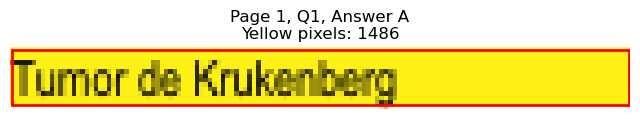

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=180.6, y1=114.7
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 720
Page 1, Q1, B: Yellow percentage: 0.0%


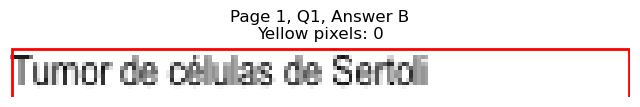

Page 1, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=403.3, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 353
Page 1, Q1, C: Yellow percentage: 0.0%


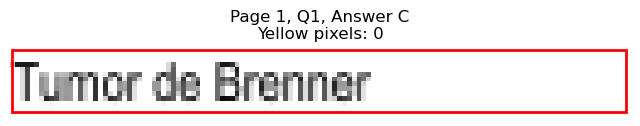

Page 1, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=380.2, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 266
Page 1, Q1, D: Yellow percentage: 0.0%


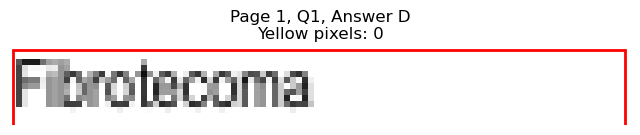


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=103.5, y1=165.2
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 205
Page 1, Q2, A: Yellow percentage: 0.0%


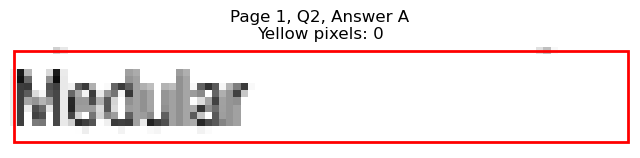

Page 1, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=104.9, y1=177.8
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 160
Page 1, Q2, B: Yellow percentage: 0.0%


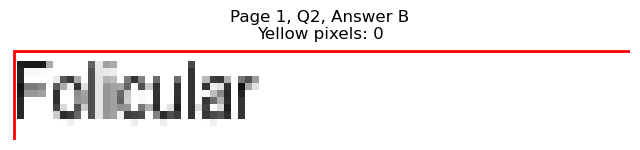

Page 1, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=358.1, y1=165.2
Page 1, Q2, C: Yellow pixels: 959
Page 1, Q2, C: Total non-white pixels: 1148
Page 1, Q2, C: Yellow percentage: 83.5%


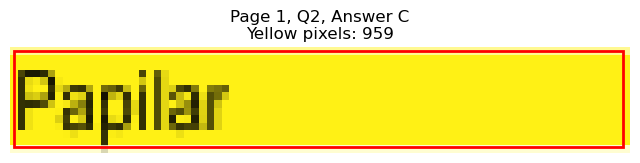

Page 1, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=374.2, y1=177.8
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 331
Page 1, Q2, D: Yellow percentage: 0.0%


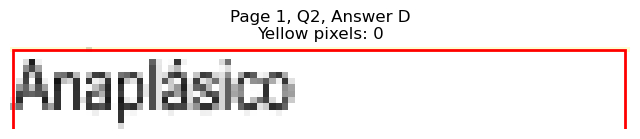


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=168.1, y1=240.9
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 509
Page 1, Q3, A: Yellow percentage: 0.0%


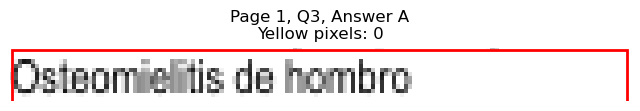

Page 1, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=143.5, y1=253.5
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 368
Page 1, Q3, B: Yellow percentage: 0.0%


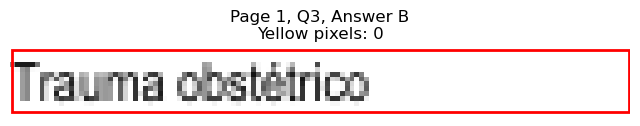

Page 1, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=393.3, y1=240.9
Page 1, Q3, C: Yellow pixels: 1251
Page 1, Q3, C: Total non-white pixels: 1521
Page 1, Q3, C: Yellow percentage: 82.2%


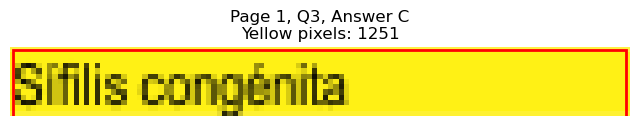

Page 1, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=386.7, y1=253.5
Page 1, Q3, D: Yellow pixels: 106
Page 1, Q3, D: Total non-white pixels: 417
Page 1, Q3, D: Yellow percentage: 25.4%


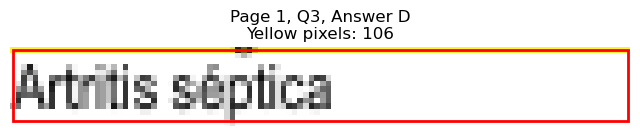


Page 1, Q3 - Selected Answer: C (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=140.5, y1=316.7
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 490
Page 1, Q4, A: Yellow percentage: 0.0%


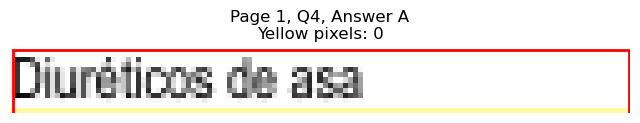

Page 1, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=156.1, y1=329.3
Page 1, Q4, B: Yellow pixels: 1308
Page 1, Q4, B: Total non-white pixels: 1946
Page 1, Q4, B: Yellow percentage: 67.2%


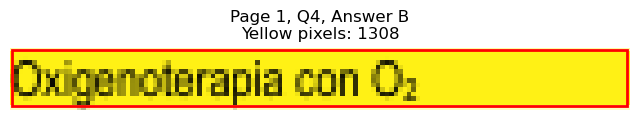

Page 1, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=462.9, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 696
Page 1, Q4, C: Yellow percentage: 0.0%


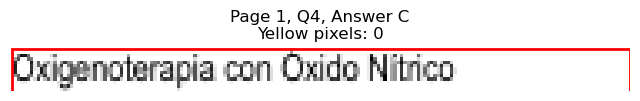

Page 1, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=389.2, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 331
Page 1, Q4, D: Yellow percentage: 0.0%


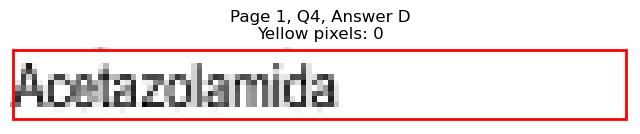


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=98.9, y1=367.2
Page 1, Q5, A: Yellow pixels: 81
Page 1, Q5, A: Total non-white pixels: 223
Page 1, Q5, A: Yellow percentage: 36.3%


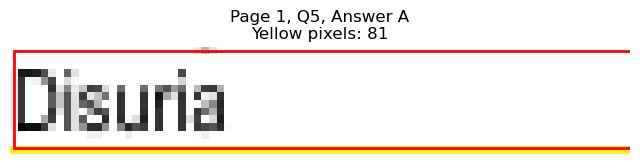

Page 1, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=141.5, y1=379.8
Page 1, Q5, B: Yellow pixels: 1326
Page 1, Q5, B: Total non-white pixels: 1612
Page 1, Q5, B: Yellow percentage: 82.3%


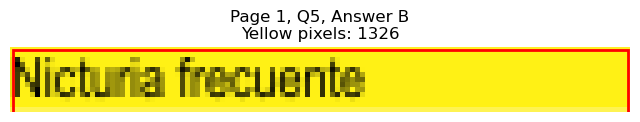

Page 1, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=410.8, y1=367.2
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 392
Page 1, Q5, C: Yellow percentage: 0.0%


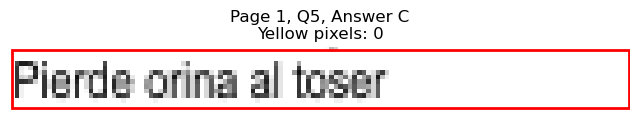

Page 1, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=427.4, y1=379.8
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 480
Page 1, Q5, D: Yellow percentage: 0.0%


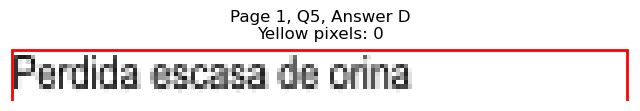


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=114.4, y1=430.3
Page 1, Q6, A: Yellow pixels: 97
Page 1, Q6, A: Total non-white pixels: 346
Page 1, Q6, A: Yellow percentage: 28.0%


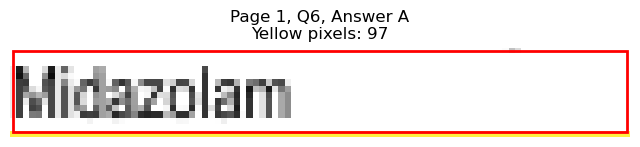

Page 1, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=121.0, y1=442.9
Page 1, Q6, B: Yellow pixels: 1113
Page 1, Q6, B: Total non-white pixels: 1339
Page 1, Q6, B: Yellow percentage: 83.1%


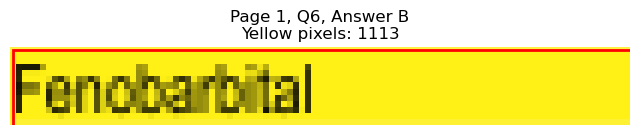

Page 1, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=370.6, y1=430.3
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 225
Page 1, Q6, C: Yellow percentage: 0.0%


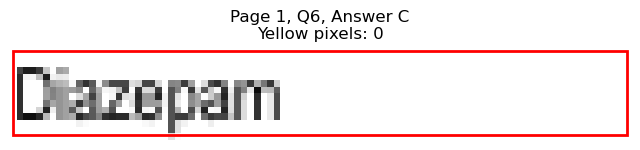

Page 1, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=367.1, y1=442.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 201
Page 1, Q6, D: Yellow percentage: 0.0%


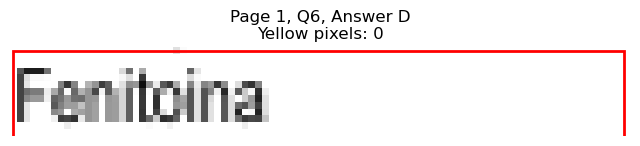


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=149.5, y1=506.0
Page 1, Q7, A: Yellow pixels: 1384
Page 1, Q7, A: Total non-white pixels: 1716
Page 1, Q7, A: Yellow percentage: 80.7%


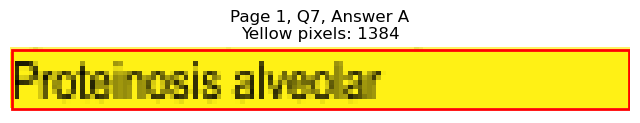

Page 1, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=151.6, y1=518.6
Page 1, Q7, B: Yellow pixels: 134
Page 1, Q7, B: Total non-white pixels: 581
Page 1, Q7, B: Yellow percentage: 23.1%


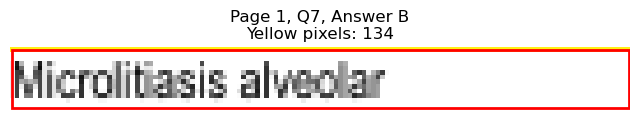

Page 1, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=478.1, y1=506.0
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 823
Page 1, Q7, C: Yellow percentage: 0.0%


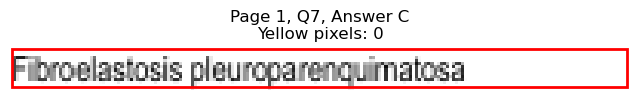

Page 1, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=454.4, y1=518.6
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 687
Page 1, Q7, D: Yellow percentage: 0.0%


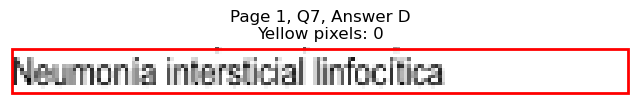


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=187.7, y1=569.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 592
Page 1, Q8, A: Yellow percentage: 0.0%


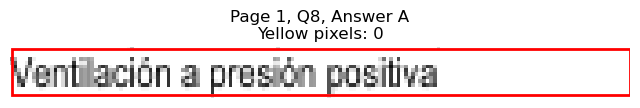

Page 1, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=171.1, y1=581.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 534
Page 1, Q8, B: Yellow percentage: 0.0%


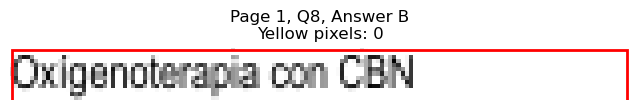

Page 1, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=436.9, y1=569.2
Page 1, Q8, C: Yellow pixels: 1659
Page 1, Q8, C: Total non-white pixels: 2240
Page 1, Q8, C: Yellow percentage: 74.1%


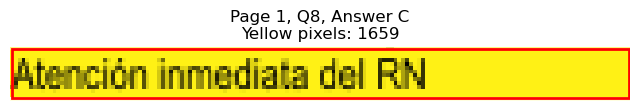

Page 1, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=409.3, y1=581.8
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 554
Page 1, Q8, D: Yellow percentage: 0.0%


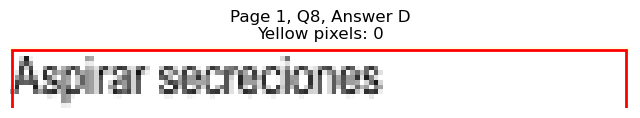


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=196.2, y1=632.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 627
Page 1, Q9, A: Yellow percentage: 0.0%


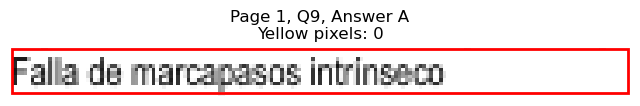

Page 1, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=183.1, y1=644.9
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 578
Page 1, Q9, B: Yellow percentage: 0.0%


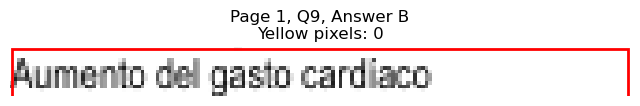

Page 1, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=455.5, y1=632.3
Page 1, Q9, C: Yellow pixels: 1648
Page 1, Q9, C: Total non-white pixels: 2506
Page 1, Q9, C: Yellow percentage: 65.8%


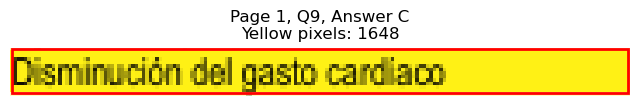

Page 1, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=464.9, y1=644.9
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 880
Page 1, Q9, D: Yellow percentage: 0.0%


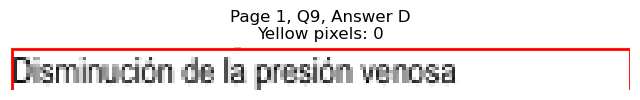


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=153.5, y1=708.0
Page 1, Q10, A: Yellow pixels: 136
Page 1, Q10, A: Total non-white pixels: 741
Page 1, Q10, A: Yellow percentage: 18.4%


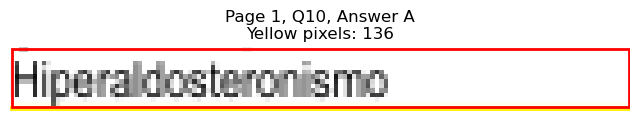

Page 1, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=164.2, y1=720.6
Page 1, Q10, B: Yellow pixels: 1542
Page 1, Q10, B: Total non-white pixels: 2058
Page 1, Q10, B: Yellow percentage: 74.9%


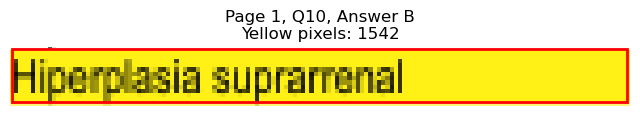

Page 1, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=399.2, y1=708.0
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 388
Page 1, Q10, C: Yellow percentage: 0.0%


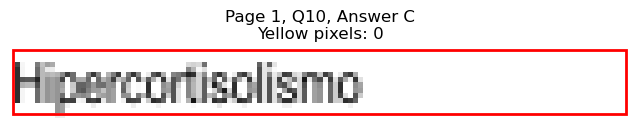

Page 1, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=392.3, y1=720.6
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 323
Page 1, Q10, D: Yellow percentage: 0.0%


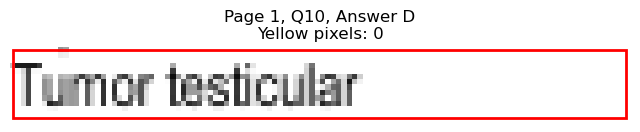


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=140.5, y1=127.3
Page 2, Q1, A: Yellow pixels: 123
Page 2, Q1, A: Total non-white pixels: 477
Page 2, Q1, A: Yellow percentage: 25.8%


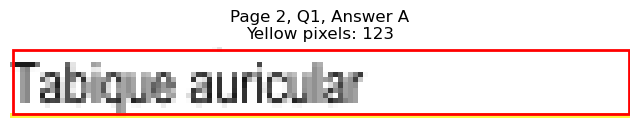

Page 2, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=147.5, y1=139.9
Page 2, Q1, B: Yellow pixels: 1351
Page 2, Q1, B: Total non-white pixels: 1690
Page 2, Q1, B: Yellow percentage: 79.9%


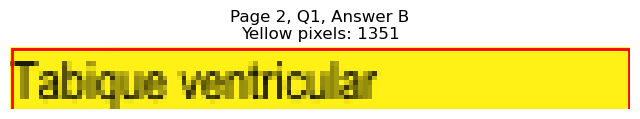

Page 2, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=387.2, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 292
Page 2, Q1, C: Yellow percentage: 0.0%


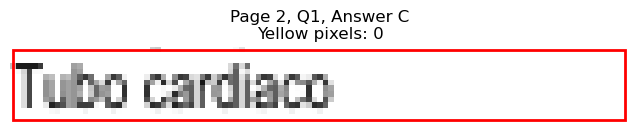

Page 2, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=408.3, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 424
Page 2, Q1, D: Yellow percentage: 0.0%


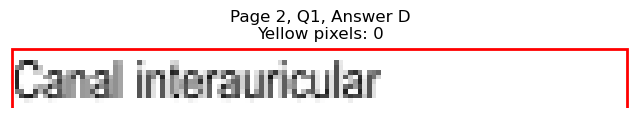


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=125.4, y1=203.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 411
Page 2, Q2, A: Yellow percentage: 0.0%


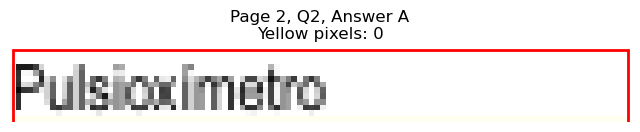

Page 2, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=118.0, y1=215.6
Page 2, Q2, B: Yellow pixels: 1095
Page 2, Q2, B: Total non-white pixels: 1400
Page 2, Q2, B: Yellow percentage: 78.2%


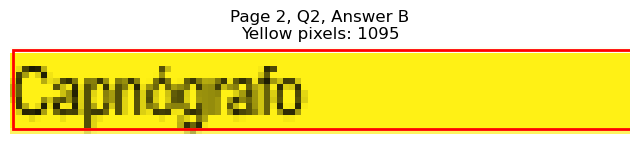

Page 2, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=461.0, y1=203.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 673
Page 2, Q2, C: Yellow percentage: 0.0%


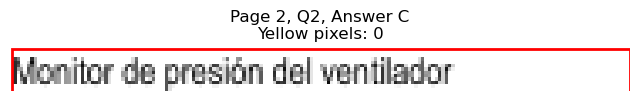

Page 2, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=419.8, y1=215.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 451
Page 2, Q2, D: Yellow percentage: 0.0%


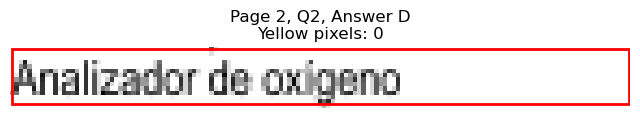


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=183.9, y1=291.5
Page 2, Q3, A: Yellow pixels: 166
Page 2, Q3, A: Total non-white pixels: 729
Page 2, Q3, A: Yellow percentage: 22.8%


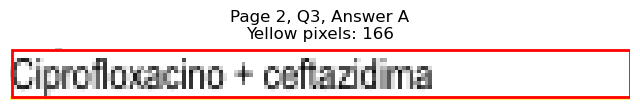

Page 2, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=181.3, y1=304.1
Page 2, Q3, B: Yellow pixels: 1689
Page 2, Q3, B: Total non-white pixels: 2296
Page 2, Q3, B: Yellow percentage: 73.6%


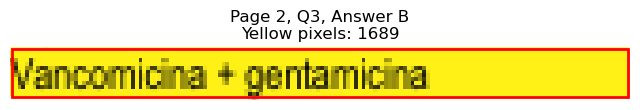

Page 2, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=468.8, y1=291.5
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 685
Page 2, Q3, C: Yellow percentage: 0.0%


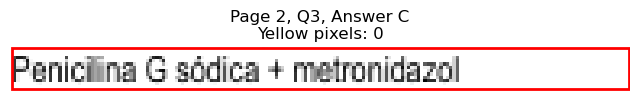

Page 2, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=432.1, y1=304.1
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 496
Page 2, Q3, D: Yellow percentage: 0.0%


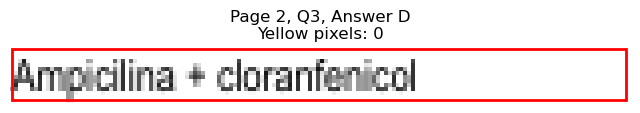


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=107.4, y1=354.6
Page 2, Q4, A: Yellow pixels: 1009
Page 2, Q4, A: Total non-white pixels: 1260
Page 2, Q4, A: Yellow percentage: 80.1%


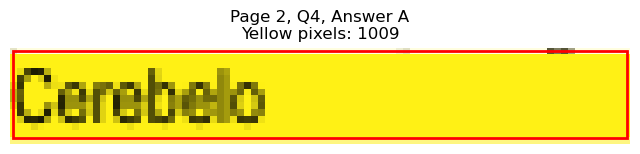

Page 2, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=128.5, y1=367.2
Page 2, Q4, B: Yellow pixels: 111
Page 2, Q4, B: Total non-white pixels: 385
Page 2, Q4, B: Yellow percentage: 28.8%


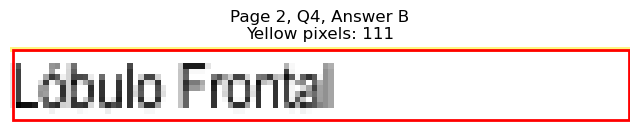

Page 2, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=399.3, y1=354.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 390
Page 2, Q4, C: Yellow percentage: 0.0%


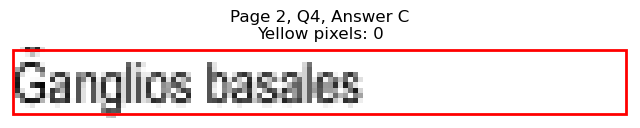

Page 2, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=394.3, y1=367.2
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 337
Page 2, Q4, D: Yellow percentage: 0.0%


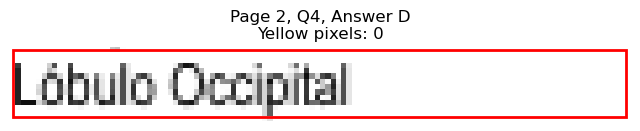


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=183.1, y1=430.3
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 584
Page 2, Q5, A: Yellow percentage: 0.0%


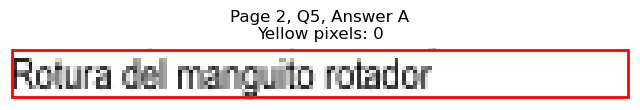

Page 2, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=154.6, y1=442.9
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 417
Page 2, Q5, B: Yellow percentage: 0.0%


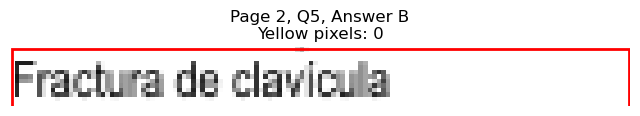

Page 2, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=426.9, y1=430.3
Page 2, Q5, C: Yellow pixels: 1438
Page 2, Q5, C: Total non-white pixels: 2100
Page 2, Q5, C: Yellow percentage: 68.5%


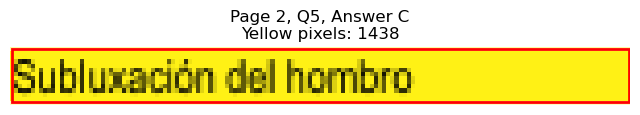

Page 2, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=442.9, y1=442.9
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 728
Page 2, Q5, D: Yellow percentage: 0.0%


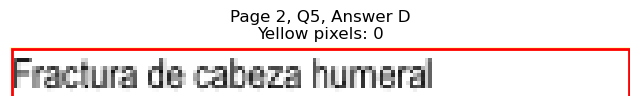


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=103.5, y1=493.4
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 181
Page 2, Q6, A: Yellow percentage: 0.0%


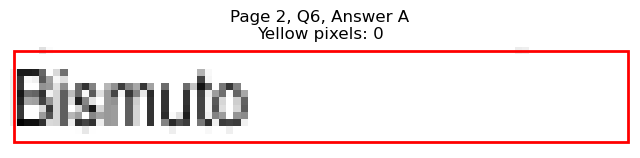

Page 2, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=109.0, y1=506.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 194
Page 2, Q6, B: Yellow percentage: 0.0%


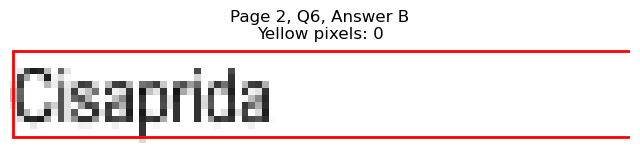

Page 2, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=378.2, y1=493.4
Page 2, Q6, C: Yellow pixels: 102
Page 2, Q6, C: Total non-white pixels: 355
Page 2, Q6, C: Yellow percentage: 28.7%


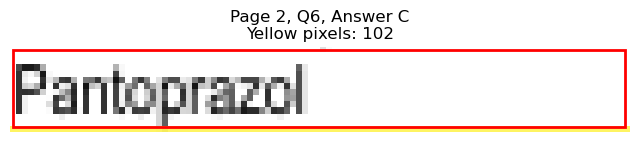

Page 2, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=372.7, y1=506.0
Page 2, Q6, D: Yellow pixels: 1052
Page 2, Q6, D: Total non-white pixels: 1248
Page 2, Q6, D: Yellow percentage: 84.3%


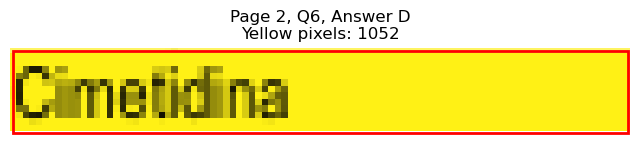


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=181.1, y1=581.8
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 542
Page 2, Q7, A: Yellow percentage: 0.0%


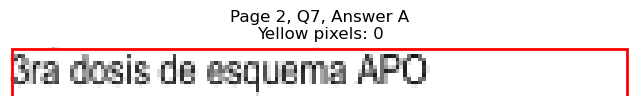

Page 2, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=195.1, y1=594.4
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 574
Page 2, Q7, B: Yellow percentage: 0.0%


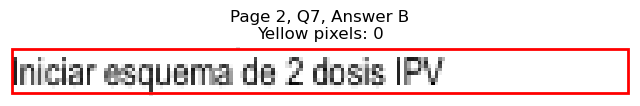

Page 2, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=422.3, y1=581.8
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 598
Page 2, Q7, C: Yellow percentage: 0.0%


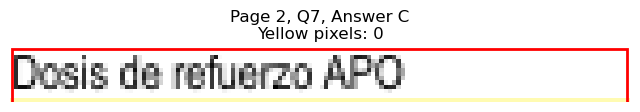

Page 2, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=454.4, y1=594.4
Page 2, Q7, D: Yellow pixels: 1669
Page 2, Q7, D: Total non-white pixels: 2492
Page 2, Q7, D: Yellow percentage: 67.0%


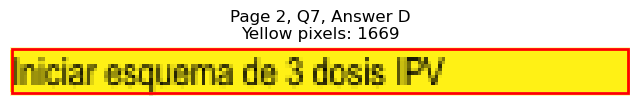


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=80.9, y1=644.9
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 55
Page 2, Q8, A: Yellow percentage: 0.0%


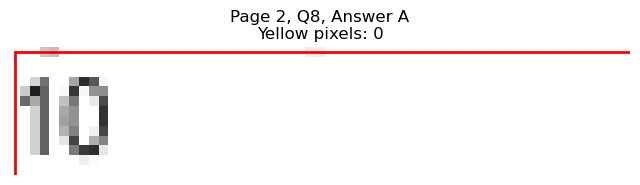

Page 2, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=80.9, y1=657.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 50
Page 2, Q8, B: Yellow percentage: 0.0%


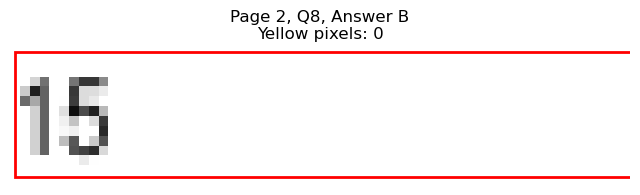

Page 2, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=340.1, y1=644.9
Page 2, Q8, C: Yellow pixels: 793
Page 2, Q8, C: Total non-white pixels: 832
Page 2, Q8, C: Yellow percentage: 95.3%


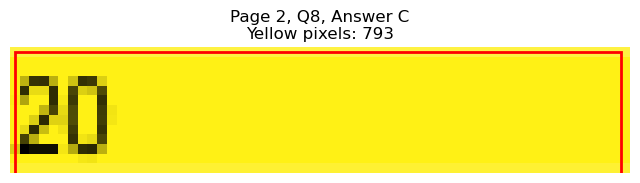

Page 2, Q8 - D: Detected box: x0=315.4, y0=644.9, x1=324.4, y1=657.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 71
Page 2, Q8, D: Yellow percentage: 0.0%


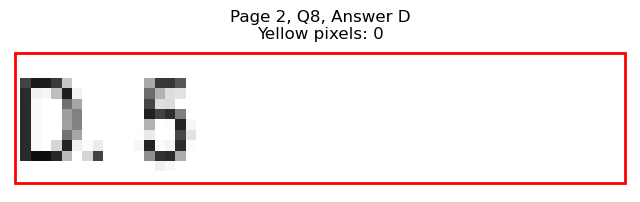


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=115.9, y1=708.0
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 230
Page 2, Q9, A: Yellow percentage: 0.0%


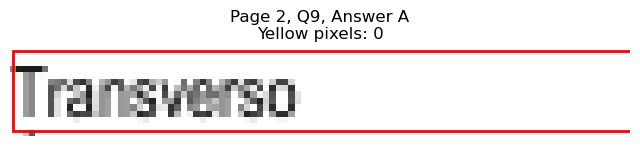

Page 2, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=135.5, y1=720.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 354
Page 2, Q9, B: Yellow percentage: 0.0%


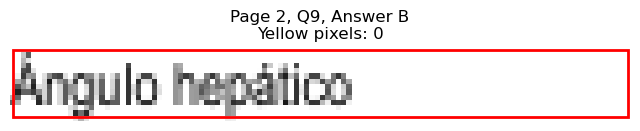

Page 2, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=353.6, y1=708.0
Page 2, Q9, C: Yellow pixels: 891
Page 2, Q9, C: Total non-white pixels: 1007
Page 2, Q9, C: Yellow percentage: 88.5%


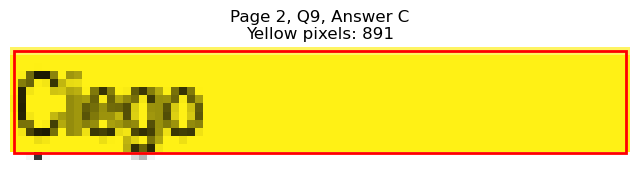

Page 2, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=398.8, y1=720.6
Page 2, Q9, D: Yellow pixels: 118
Page 2, Q9, D: Total non-white pixels: 486
Page 2, Q9, D: Yellow percentage: 24.3%


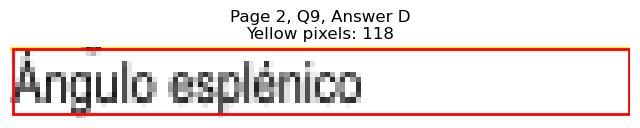


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=204.8, y1=127.3
Page 3, Q1, A: Yellow pixels: 1713
Page 3, Q1, A: Total non-white pixels: 2618
Page 3, Q1, A: Yellow percentage: 65.4%


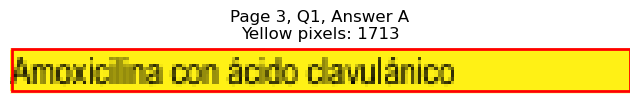

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=125.9, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 394
Page 3, Q1, B: Yellow percentage: 0.0%


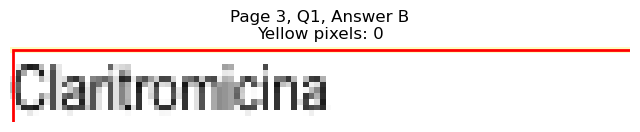

Page 3, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=380.2, y1=127.3
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 275
Page 3, Q1, C: Yellow percentage: 0.0%


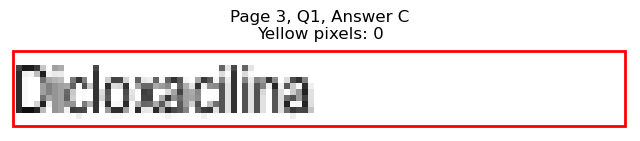

Page 3, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=373.1, y1=139.9
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 240
Page 3, Q1, D: Yellow percentage: 0.0%


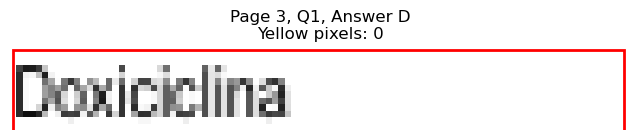


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=163.1, y1=215.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 467
Page 3, Q2, A: Yellow percentage: 0.0%


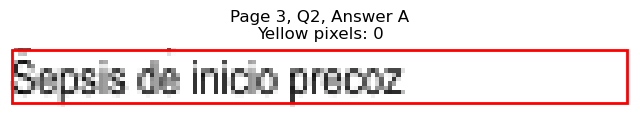

Page 3, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=156.1, y1=228.3
Page 3, Q2, B: Yellow pixels: 1343
Page 3, Q2, B: Total non-white pixels: 1946
Page 3, Q2, B: Yellow percentage: 69.0%


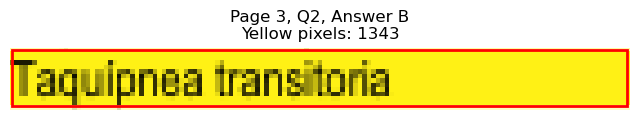

Page 3, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=434.3, y1=215.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 557
Page 3, Q2, C: Yellow percentage: 0.0%


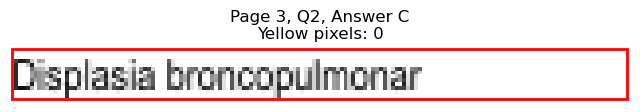

Page 3, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=418.4, y1=228.3
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 495
Page 3, Q2, D: Yellow percentage: 0.0%


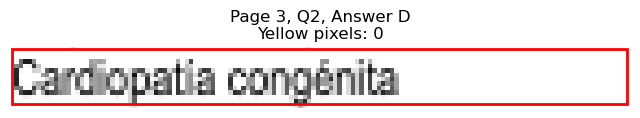


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=127.5, y1=266.1
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 294
Page 3, Q3, A: Yellow percentage: 0.0%


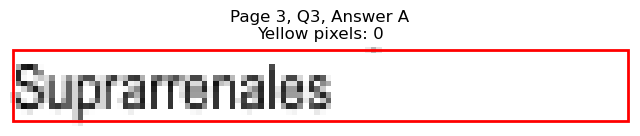

Page 3, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=110.9, y1=278.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 220
Page 3, Q3, B: Yellow percentage: 0.0%


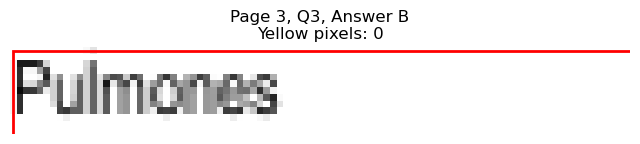

Page 3, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=363.2, y1=266.1
Page 3, Q3, C: Yellow pixels: 87
Page 3, Q3, C: Total non-white pixels: 278
Page 3, Q3, C: Yellow percentage: 31.3%


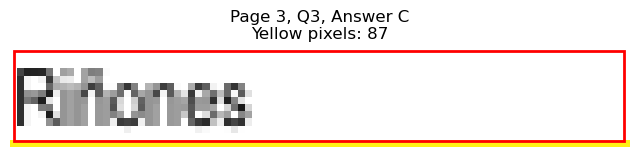

Page 3, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=386.2, y1=278.7
Page 3, Q3, D: Yellow pixels: 1203
Page 3, Q3, D: Total non-white pixels: 1430
Page 3, Q3, D: Yellow percentage: 84.1%


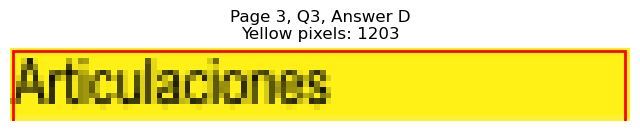


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=191.2, y1=329.3
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 619
Page 3, Q4, A: Yellow percentage: 0.0%


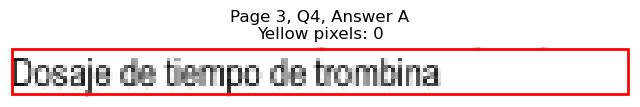

Page 3, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=173.7, y1=341.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 523
Page 3, Q4, B: Yellow percentage: 0.0%


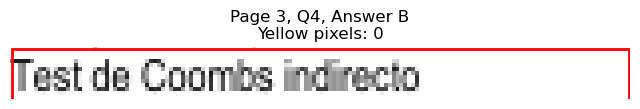

Page 3, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=387.8, y1=329.3
Page 3, Q4, C: Yellow pixels: 1119
Page 3, Q4, C: Total non-white pixels: 1554
Page 3, Q4, C: Yellow percentage: 72.0%


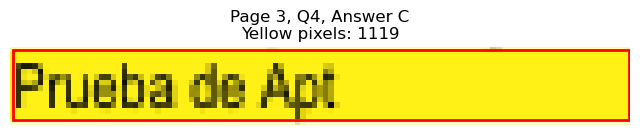

Page 3, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=370.1, y1=341.9
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 295
Page 3, Q4, D: Yellow percentage: 0.0%


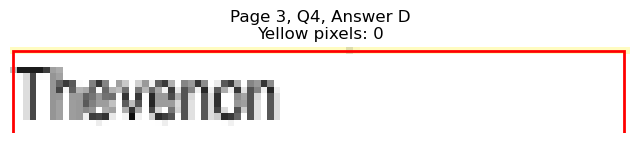


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=121.5, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 276
Page 3, Q5, A: Yellow percentage: 0.0%


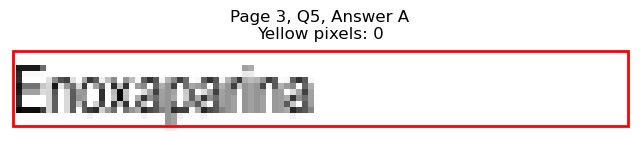

Page 3, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=121.5, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 274
Page 3, Q5, B: Yellow percentage: 0.0%


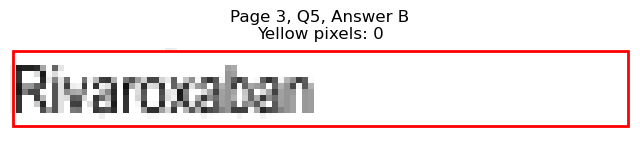

Page 3, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=369.2, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 217
Page 3, Q5, C: Yellow percentage: 0.0%


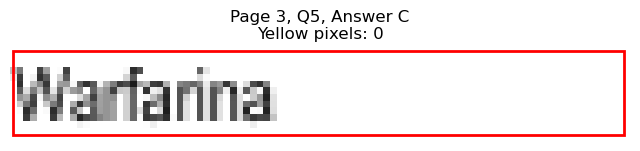

Page 3, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=367.1, y1=430.3
Page 3, Q5, D: Yellow pixels: 921
Page 3, Q5, D: Total non-white pixels: 1274
Page 3, Q5, D: Yellow percentage: 72.3%


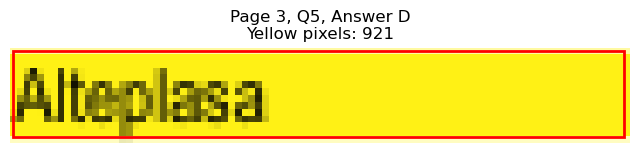


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=159.1, y1=468.1
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 440
Page 3, Q6, A: Yellow percentage: 0.0%


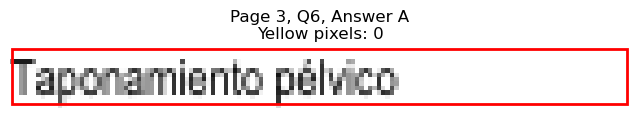

Page 3, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=117.0, y1=480.7
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 266
Page 3, Q6, B: Yellow percentage: 0.0%


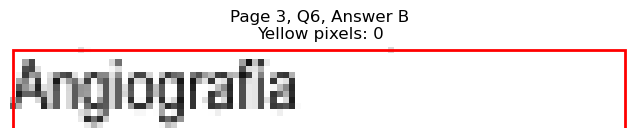

Page 3, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=460.9, y1=468.1
Page 3, Q6, C: Yellow pixels: 1886
Page 3, Q6, C: Total non-white pixels: 2576
Page 3, Q6, C: Yellow percentage: 73.2%


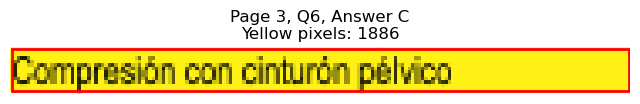

Page 3, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=462.4, y1=480.7
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 891
Page 3, Q6, D: Yellow percentage: 0.0%


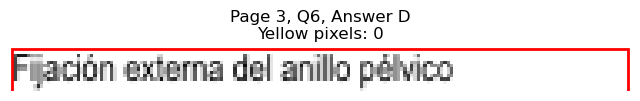


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=65.2, y1=531.2
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 59
Page 3, Q7, A: Yellow percentage: 0.0%


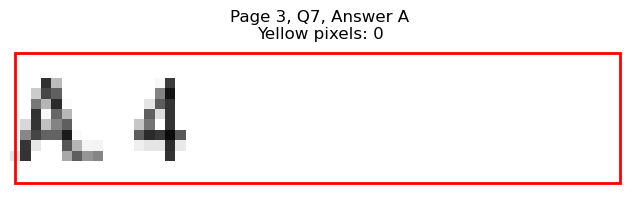

Page 3, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=65.2, y1=543.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 60
Page 3, Q7, B: Yellow percentage: 0.0%


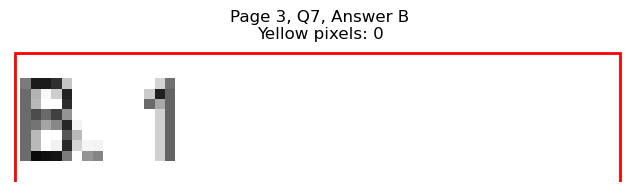

Page 3, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=324.4, y1=531.2
Page 3, Q7, C: Yellow pixels: 60
Page 3, Q7, C: Total non-white pixels: 126
Page 3, Q7, C: Yellow percentage: 47.6%


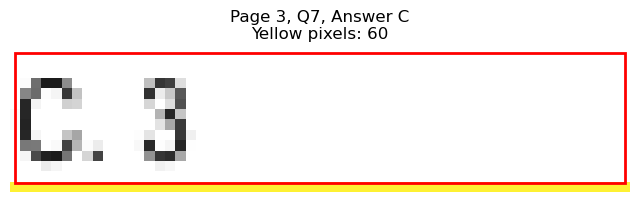

Page 3, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=324.4, y1=543.8
Page 3, Q7, D: Yellow pixels: 731
Page 3, Q7, D: Total non-white pixels: 780
Page 3, Q7, D: Yellow percentage: 93.7%


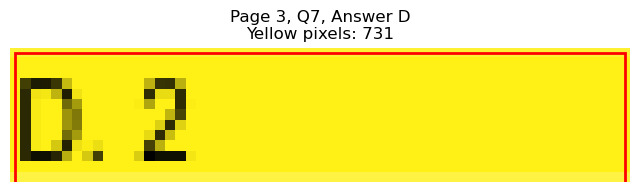


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=163.1, y1=594.4
Page 3, Q8, A: Yellow pixels: 146
Page 3, Q8, A: Total non-white pixels: 594
Page 3, Q8, A: Yellow percentage: 24.6%


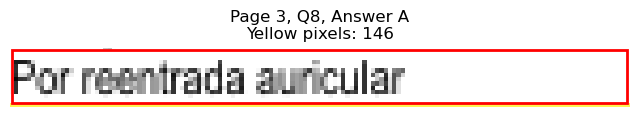

Page 3, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=147.0, y1=607.0
Page 3, Q8, B: Yellow pixels: 1355
Page 3, Q8, B: Total non-white pixels: 1690
Page 3, Q8, B: Yellow percentage: 80.2%


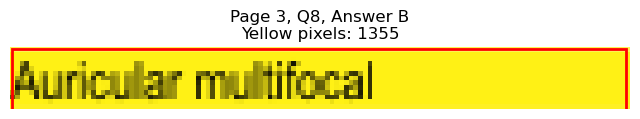

Page 3, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=452.9, y1=594.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 618
Page 3, Q8, C: Yellow percentage: 0.0%


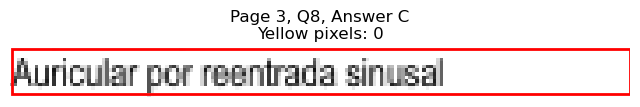

Page 3, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=365.8, y1=607.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 176
Page 3, Q8, D: Yellow percentage: 0.0%


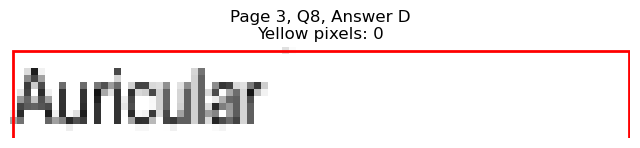


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=162.6, y1=657.5
Page 3, Q9, A: Yellow pixels: 145
Page 3, Q9, A: Total non-white pixels: 611
Page 3, Q9, A: Yellow percentage: 23.7%


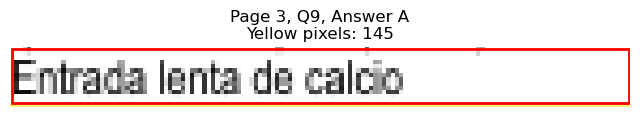

Page 3, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=211.8, y1=670.1
Page 3, Q9, B: Yellow pixels: 1955
Page 3, Q9, B: Total non-white pixels: 2716
Page 3, Q9, B: Yellow percentage: 72.0%


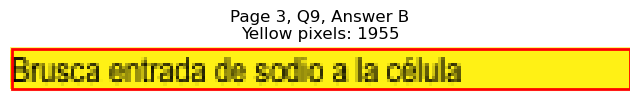

Page 3, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=469.5, y1=657.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 697
Page 3, Q9, C: Yellow percentage: 0.0%


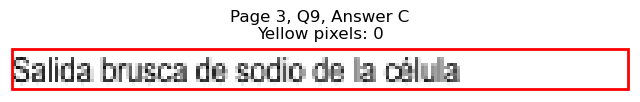

Page 3, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=464.5, y1=670.1
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 669
Page 3, Q9, D: Yellow percentage: 0.0%


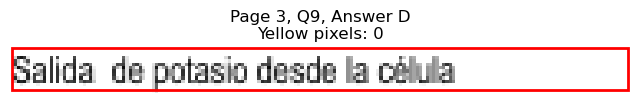


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=124.0, y1=733.2
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 286
Page 3, Q10, A: Yellow percentage: 0.0%


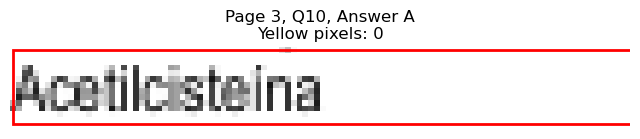

Page 3, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=119.4, y1=745.8
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 253
Page 3, Q10, B: Yellow percentage: 0.0%


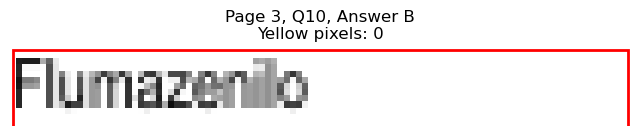

Page 3, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=395.7, y1=733.2
Page 3, Q10, C: Yellow pixels: 119
Page 3, Q10, C: Total non-white pixels: 459
Page 3, Q10, C: Yellow percentage: 25.9%


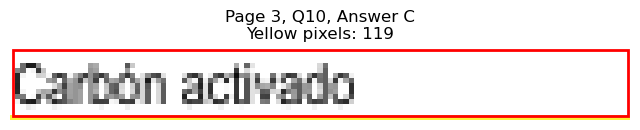

Page 3, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=425.8, y1=745.8
Page 3, Q10, D: Yellow pixels: 1545
Page 3, Q10, D: Total non-white pixels: 1937
Page 3, Q10, D: Yellow percentage: 79.8%


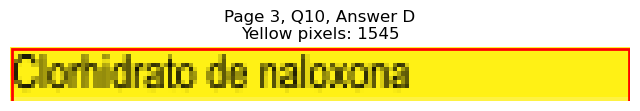


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=152.5, x1=150.0, y1=165.2
Page 4, Q1, A: Yellow pixels: 133
Page 4, Q1, A: Total non-white pixels: 536
Page 4, Q1, A: Yellow percentage: 24.8%


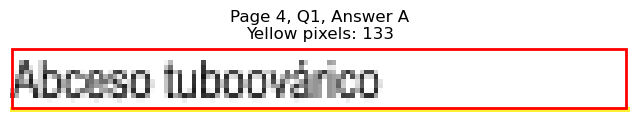

Page 4, Q1 - B: Detected box: x0=68.3, y0=165.1, x1=170.7, y1=177.8
Page 4, Q1, B: Yellow pixels: 1600
Page 4, Q1, B: Total non-white pixels: 1989
Page 4, Q1, B: Yellow percentage: 80.4%


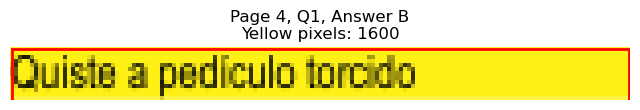

Page 4, Q1 - C: Detected box: x0=327.5, y0=152.5, x1=406.7, y1=165.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 374
Page 4, Q1, C: Yellow percentage: 0.0%


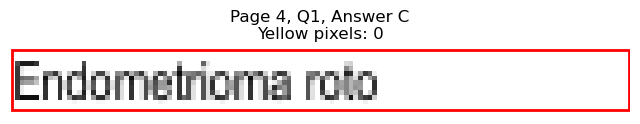

Page 4, Q1 - D: Detected box: x0=327.5, y0=165.1, x1=403.3, y1=177.8
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 353
Page 4, Q1, D: Yellow percentage: 0.0%


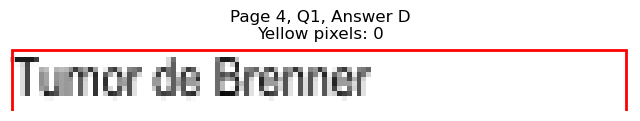


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=105.9, y1=228.3
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 191
Page 4, Q2, A: Yellow percentage: 0.0%


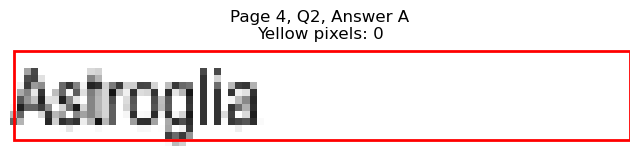

Page 4, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=109.5, y1=240.9
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 224
Page 4, Q2, B: Yellow percentage: 0.0%


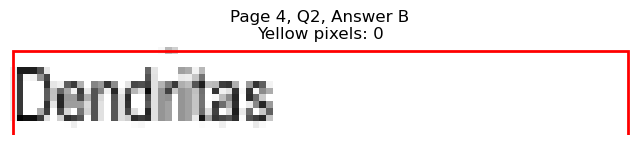

Page 4, Q2 - C: Detected box: x0=327.5, y0=215.7, x1=358.6, y1=228.3
Page 4, Q2, C: Yellow pixels: 833
Page 4, Q2, C: Total non-white pixels: 1148
Page 4, Q2, C: Yellow percentage: 72.6%


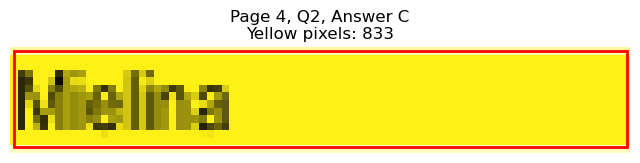

Page 4, Q2 - D: Detected box: x0=327.5, y0=228.3, x1=393.3, y1=240.9
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 447
Page 4, Q2, D: Yellow percentage: 0.0%


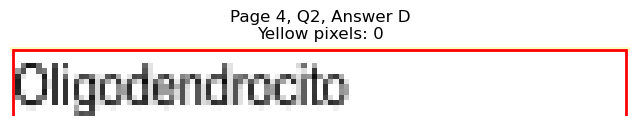


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=106.9, y1=278.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 197
Page 4, Q3, A: Yellow percentage: 0.0%


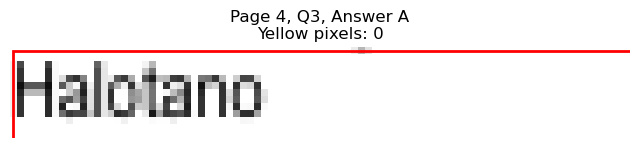

Page 4, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=118.9, y1=291.5
Page 4, Q3, B: Yellow pixels: 1129
Page 4, Q3, B: Total non-white pixels: 1414
Page 4, Q3, B: Yellow percentage: 79.8%


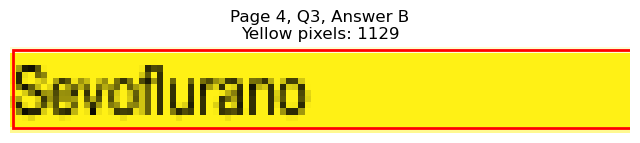

Page 4, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=369.7, y1=278.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 222
Page 4, Q3, C: Yellow percentage: 0.0%


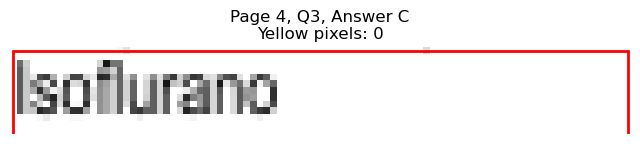

Page 4, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=368.7, y1=291.5
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 201
Page 4, Q3, D: Yellow percentage: 0.0%


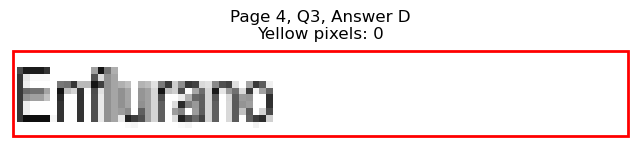


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=204.8, y1=367.2
Page 4, Q4, A: Yellow pixels: 187
Page 4, Q4, A: Total non-white pixels: 863
Page 4, Q4, A: Yellow percentage: 21.7%


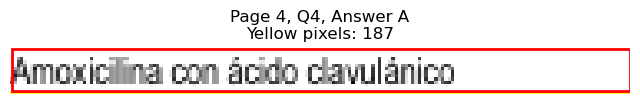

Page 4, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=126.0, y1=379.8
Page 4, Q4, B: Yellow pixels: 1206
Page 4, Q4, B: Total non-white pixels: 1417
Page 4, Q4, B: Yellow percentage: 85.1%


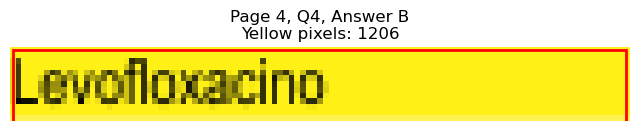

Page 4, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=372.7, y1=367.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 231
Page 4, Q4, C: Yellow percentage: 0.0%


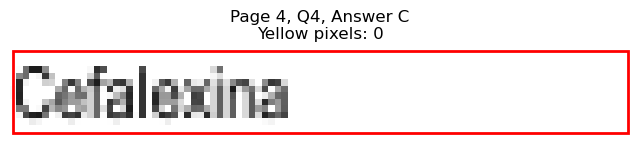

Page 4, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=373.1, y1=379.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 240
Page 4, Q4, D: Yellow percentage: 0.0%


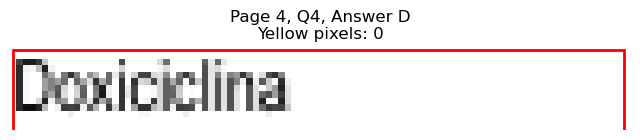


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=164.5, y1=417.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 481
Page 4, Q5, A: Yellow percentage: 0.0%


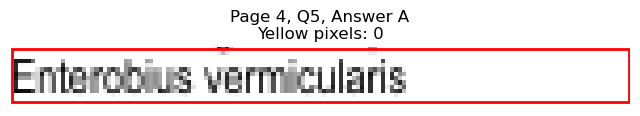

Page 4, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=153.5, y1=430.3
Page 4, Q5, B: Yellow pixels: 1308
Page 4, Q5, B: Total non-white pixels: 1904
Page 4, Q5, B: Yellow percentage: 68.7%


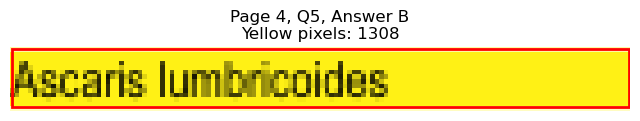

Page 4, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=432.4, y1=417.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 537
Page 4, Q5, C: Yellow percentage: 0.0%


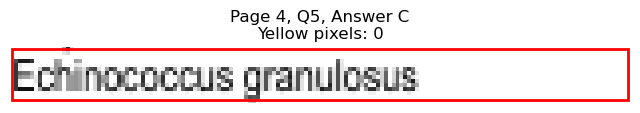

Page 4, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=406.7, y1=430.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 381
Page 4, Q5, D: Yellow percentage: 0.0%


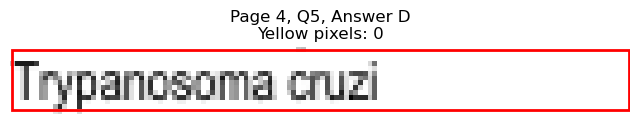


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=151.1, y1=493.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 412
Page 4, Q6, A: Yellow percentage: 0.0%


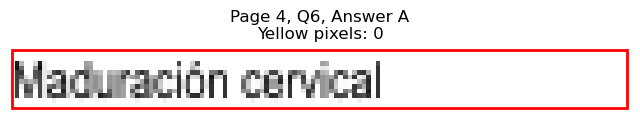

Page 4, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=165.6, y1=506.0
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 501
Page 4, Q6, B: Yellow percentage: 0.0%


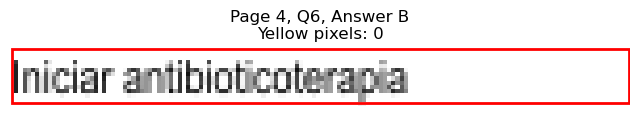

Page 4, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=449.0, y1=493.4
Page 4, Q6, C: Yellow pixels: 1593
Page 4, Q6, C: Total non-white pixels: 2408
Page 4, Q6, C: Yellow percentage: 66.2%


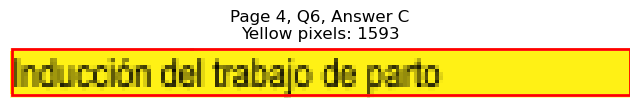

Page 4, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=444.1, y1=506.0
Page 4, Q6, D: Yellow pixels: 3
Page 4, Q6, D: Total non-white pixels: 776
Page 4, Q6, D: Yellow percentage: 0.4%


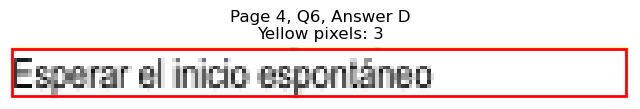


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=177.1, y1=569.2
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 520
Page 4, Q7, A: Yellow percentage: 0.0%


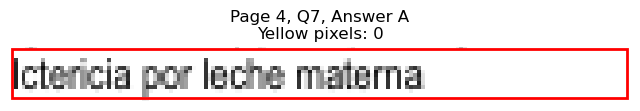

Page 4, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=144.0, y1=581.8
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 399
Page 4, Q7, B: Yellow percentage: 0.0%


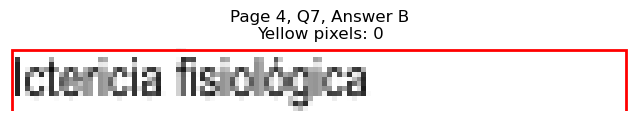

Page 4, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=501.1, y1=569.2
Page 4, Q7, C: Yellow pixels: 213
Page 4, Q7, C: Total non-white pixels: 1084
Page 4, Q7, C: Yellow percentage: 19.6%


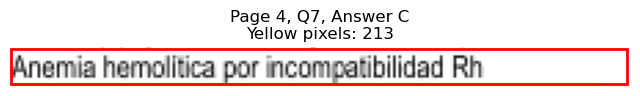

Page 4, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=508.5, y1=581.8
Page 4, Q7, D: Yellow pixels: 2048
Page 4, Q7, D: Total non-white pixels: 2782
Page 4, Q7, D: Yellow percentage: 73.6%


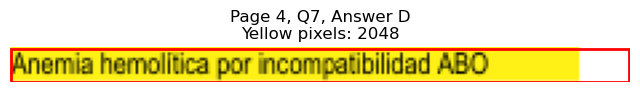


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=115.0, y1=632.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 231
Page 4, Q8, A: Yellow percentage: 0.0%


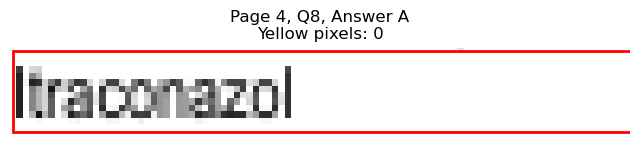

Page 4, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=114.5, y1=644.9
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 216
Page 4, Q8, B: Yellow percentage: 0.0%


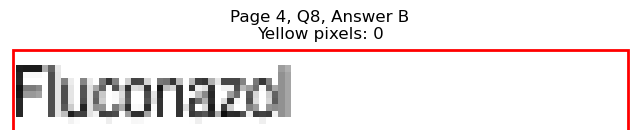

Page 4, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=377.2, y1=632.3
Page 4, Q8, C: Yellow pixels: 1042
Page 4, Q8, C: Total non-white pixels: 1414
Page 4, Q8, C: Yellow percentage: 73.7%


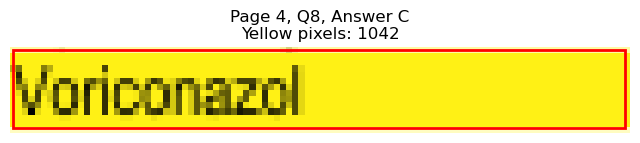

Page 4, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=386.2, y1=644.9
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 405
Page 4, Q8, D: Yellow percentage: 0.0%


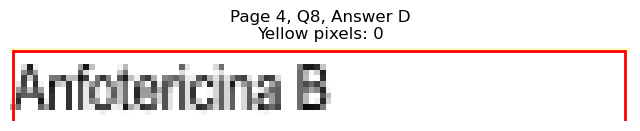


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=90.9, y1=708.0
Page 4, Q9, A: Yellow pixels: 73
Page 4, Q9, A: Total non-white pixels: 246
Page 4, Q9, A: Yellow percentage: 29.7%


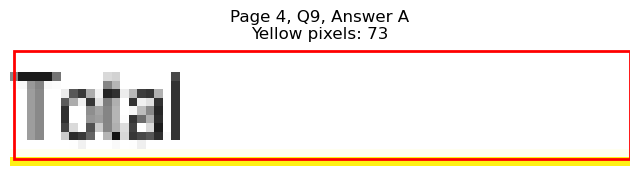

Page 4, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=103.9, y1=720.6
Page 4, Q9, B: Yellow pixels: 982
Page 4, Q9, B: Total non-white pixels: 1204
Page 4, Q9, B: Yellow percentage: 81.6%


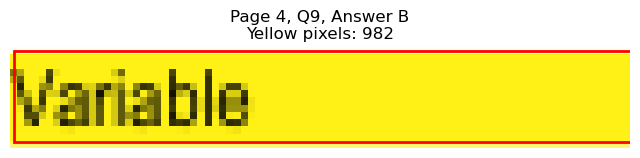

Page 4, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=364.6, y1=708.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 212
Page 4, Q9, C: Yellow percentage: 0.0%


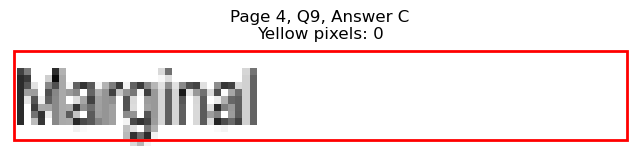

Page 4, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=344.6, y1=720.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 100
Page 4, Q9, D: Yellow percentage: 0.0%


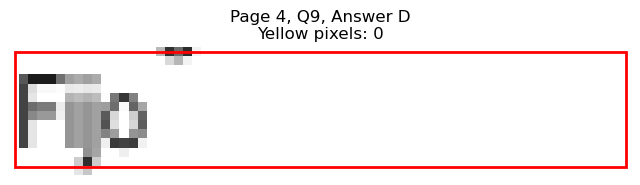


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=167.7, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 514
Page 5, Q1, A: Yellow percentage: 0.0%


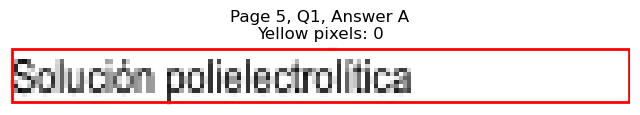

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=152.5, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 397
Page 5, Q1, B: Yellow percentage: 0.0%


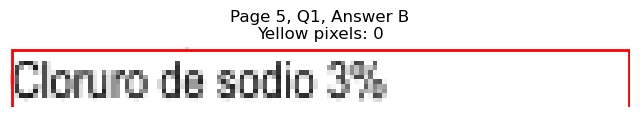

Page 5, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=404.2, y1=127.3
Page 5, Q1, C: Yellow pixels: 1226
Page 5, Q1, C: Total non-white pixels: 1792
Page 5, Q1, C: Yellow percentage: 68.4%


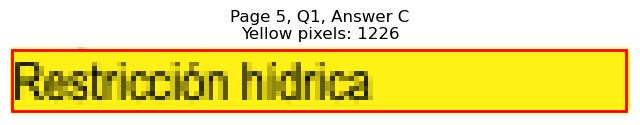

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=377.7, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 358
Page 5, Q1, D: Yellow percentage: 0.0%


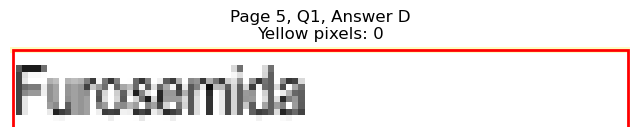


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=156.0, y1=203.0
Page 5, Q2, A: Yellow pixels: 1443
Page 5, Q2, A: Total non-white pixels: 1807
Page 5, Q2, A: Yellow percentage: 79.9%


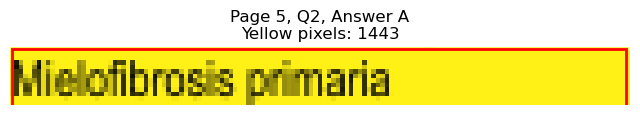

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=188.2, y1=215.6
Page 5, Q2, B: Yellow pixels: 169
Page 5, Q2, B: Total non-white pixels: 768
Page 5, Q2, B: Yellow percentage: 22.0%


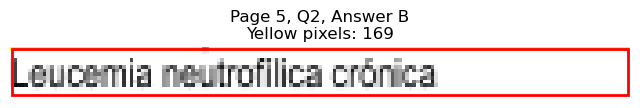

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=425.3, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 500
Page 5, Q2, C: Yellow percentage: 0.0%


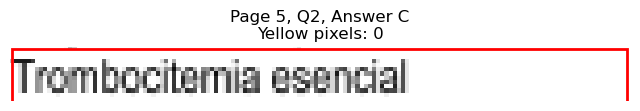

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=448.4, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 585
Page 5, Q2, D: Yellow percentage: 0.0%


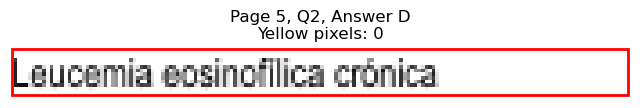


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=134.5, y1=278.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 336
Page 5, Q3, A: Yellow percentage: 0.0%


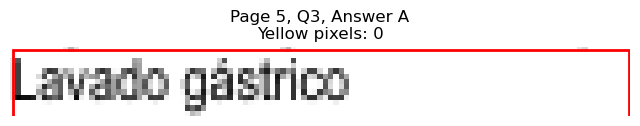

Page 5, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=115.9, y1=291.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 256
Page 5, Q3, B: Yellow percentage: 0.0%


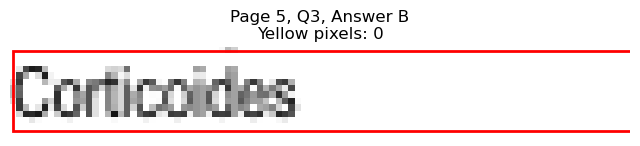

Page 5, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=409.3, y1=278.7
Page 5, Q3, C: Yellow pixels: 1407
Page 5, Q3, C: Total non-white pixels: 1729
Page 5, Q3, C: Yellow percentage: 81.4%


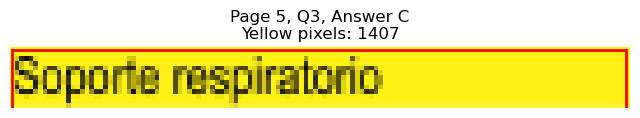

Page 5, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=395.7, y1=291.5
Page 5, Q3, D: Yellow pixels: 119
Page 5, Q3, D: Total non-white pixels: 459
Page 5, Q3, D: Yellow percentage: 25.9%


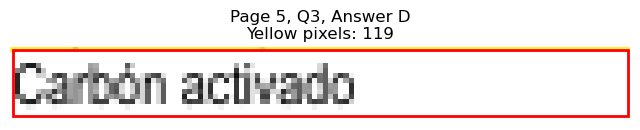


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=90.9, y1=329.3
Page 5, Q4, A: Yellow pixels: 73
Page 5, Q4, A: Total non-white pixels: 179
Page 5, Q4, A: Yellow percentage: 40.8%


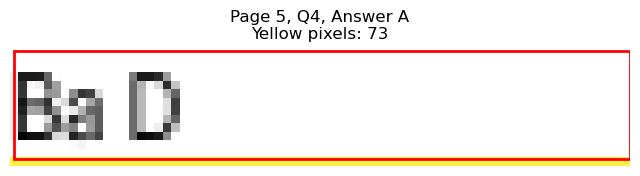

Page 5, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=95.4, y1=341.9
Page 5, Q4, B: Yellow pixels: 908
Page 5, Q4, B: Total non-white pixels: 1014
Page 5, Q4, B: Yellow percentage: 89.5%


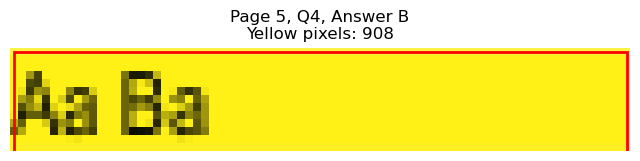

Page 5, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=354.7, y1=329.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 129
Page 5, Q4, C: Yellow percentage: 0.0%


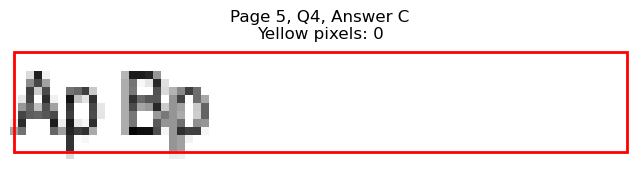

Page 5, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=350.1, y1=341.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 92
Page 5, Q4, D: Yellow percentage: 0.0%


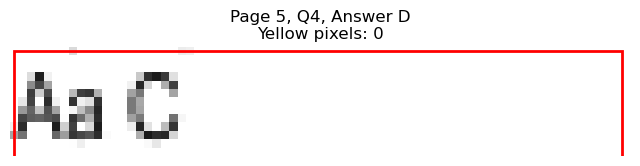


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=107.9, y1=405.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 294
Page 5, Q5, A: Yellow percentage: 0.0%


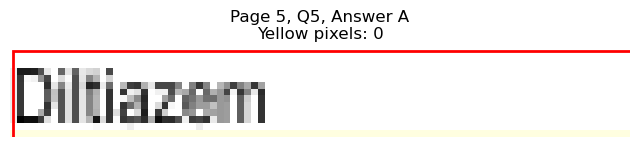

Page 5, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=166.6, y1=417.6
Page 5, Q5, B: Yellow pixels: 1475
Page 5, Q5, B: Total non-white pixels: 2086
Page 5, Q5, B: Yellow percentage: 70.7%


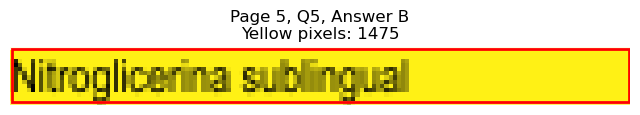

Page 5, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=374.7, y1=405.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 249
Page 5, Q5, C: Yellow percentage: 0.0%


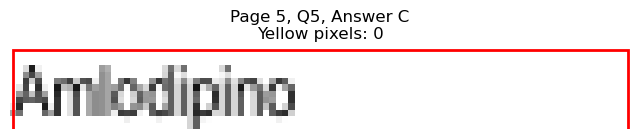

Page 5, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=371.7, y1=417.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 234
Page 5, Q5, D: Yellow percentage: 0.0%


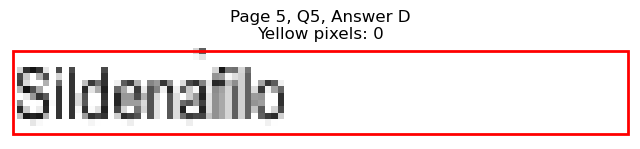


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=257.6, y1=468.1
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 975
Page 5, Q6, A: Yellow percentage: 0.0%


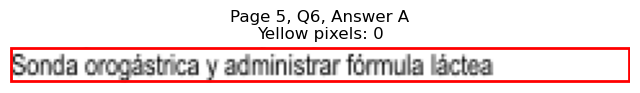

Page 5, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=186.6, y1=480.7
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 574
Page 5, Q6, B: Yellow percentage: 0.0%


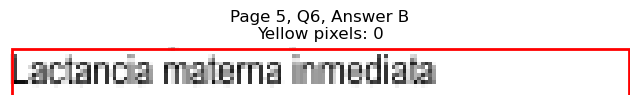

Page 5, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=412.3, y1=468.1
Page 5, Q6, C: Yellow pixels: 1459
Page 5, Q6, C: Total non-white pixels: 1904
Page 5, Q6, C: Yellow percentage: 76.6%


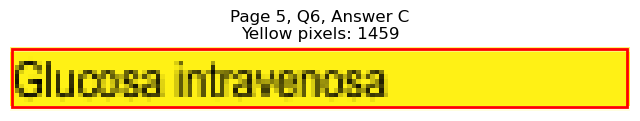

Page 5, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=429.3, y1=480.7
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 675
Page 5, Q6, D: Yellow percentage: 0.0%


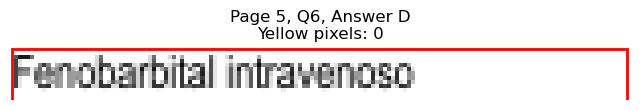


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=234.3, y1=556.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 858
Page 5, Q7, A: Yellow percentage: 0.0%


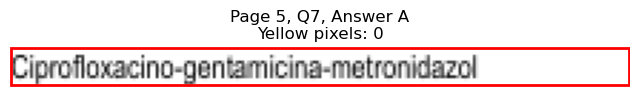

Page 5, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=220.2, y1=569.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 817
Page 5, Q7, B: Yellow percentage: 0.0%


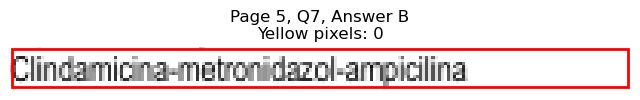

Page 5, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=482.5, y1=556.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 775
Page 5, Q7, C: Yellow percentage: 0.0%


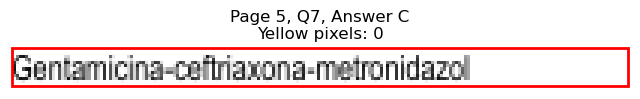

Page 5, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=486.6, y1=569.2
Page 5, Q7, D: Yellow pixels: 2101
Page 5, Q7, D: Total non-white pixels: 2940
Page 5, Q7, D: Yellow percentage: 71.5%


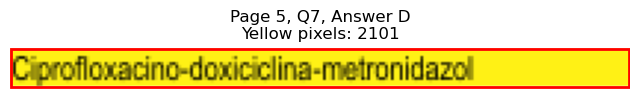


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=203.7, y1=632.3
Page 5, Q8, A: Yellow pixels: 186
Page 5, Q8, A: Total non-white pixels: 882
Page 5, Q8, A: Yellow percentage: 21.1%


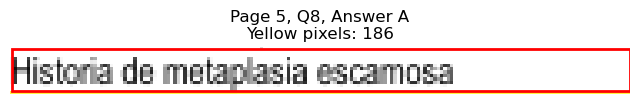

Page 5, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=140.1, y1=644.9
Page 5, Q8, B: Yellow pixels: 1326
Page 5, Q8, B: Total non-white pixels: 1599
Page 5, Q8, B: Yellow percentage: 82.9%


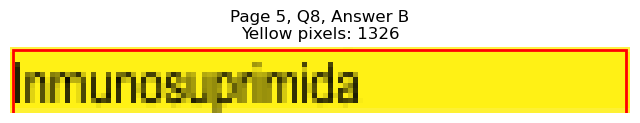

Page 5, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=463.5, y1=632.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 708
Page 5, Q8, C: Yellow percentage: 0.0%


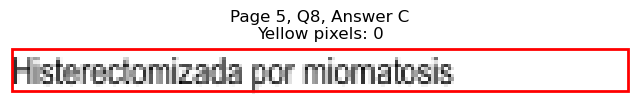

Page 5, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=419.3, y1=644.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 442
Page 5, Q8, D: Yellow percentage: 0.0%


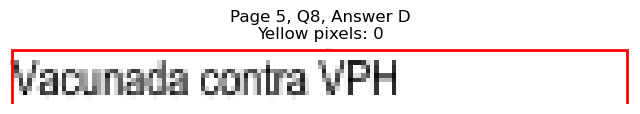


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=102.9, y1=695.3
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 172
Page 5, Q9, A: Yellow percentage: 0.0%


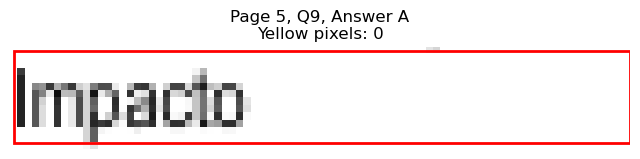

Page 5, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=112.0, y1=708.0
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 209
Page 5, Q9, B: Yellow percentage: 0.0%


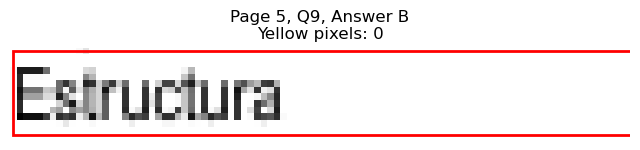

Page 5, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=363.2, y1=695.3
Page 5, Q9, C: Yellow pixels: 918
Page 5, Q9, C: Total non-white pixels: 1218
Page 5, Q9, C: Yellow percentage: 75.4%


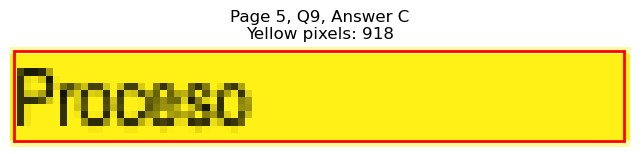

Page 5, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=368.2, y1=708.0
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 316
Page 5, Q9, D: Yellow percentage: 0.0%


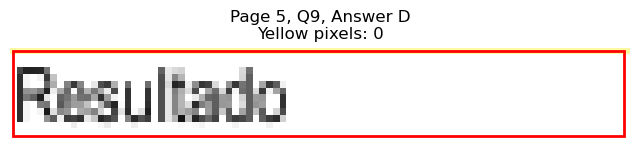


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=112.0, y1=127.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 227
Page 6, Q1, A: Yellow percentage: 0.0%


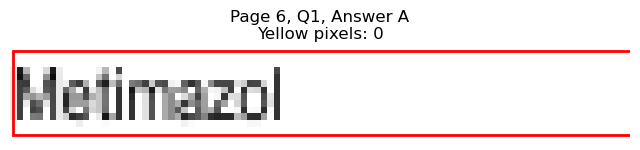

Page 6, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=113.9, y1=139.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 217
Page 6, Q1, B: Yellow percentage: 0.0%


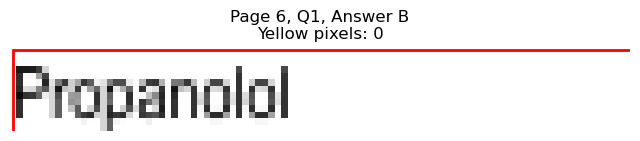

Page 6, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=423.3, y1=127.3
Page 6, Q1, C: Yellow pixels: 1401
Page 6, Q1, C: Total non-white pixels: 2058
Page 6, Q1, C: Yellow percentage: 68.1%


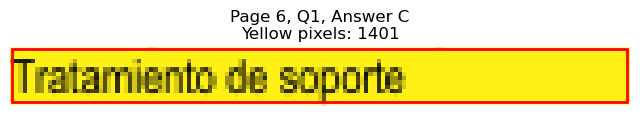

Page 6, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=389.2, y1=139.9
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 427
Page 6, Q1, D: Yellow percentage: 0.0%


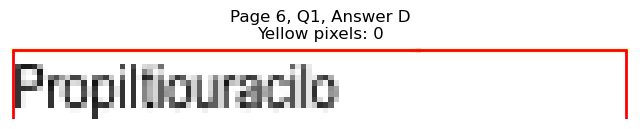


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=182.2, y1=215.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 600
Page 6, Q2, A: Yellow percentage: 0.0%


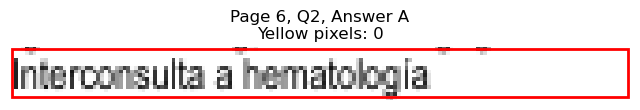

Page 6, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=208.2, y1=228.3
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 696
Page 6, Q2, B: Yellow percentage: 0.0%


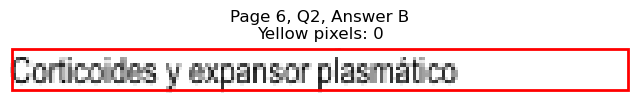

Page 6, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=463.9, y1=215.6
Page 6, Q2, C: Yellow pixels: 1917
Page 6, Q2, C: Total non-white pixels: 2618
Page 6, Q2, C: Yellow percentage: 73.2%


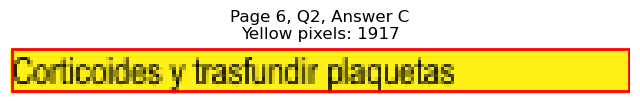

Page 6, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=444.4, y1=228.3
Page 6, Q2, D: Yellow pixels: 167
Page 6, Q2, D: Total non-white pixels: 757
Page 6, Q2, D: Yellow percentage: 22.1%


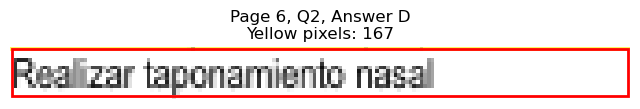


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=101.9, y1=291.5
Page 6, Q3, A: Yellow pixels: 84
Page 6, Q3, A: Total non-white pixels: 216
Page 6, Q3, A: Yellow percentage: 38.9%


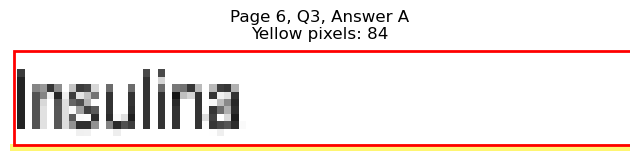

Page 6, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=150.0, y1=304.1
Page 6, Q3, B: Yellow pixels: 1411
Page 6, Q3, B: Total non-white pixels: 1862
Page 6, Q3, B: Yellow percentage: 75.8%


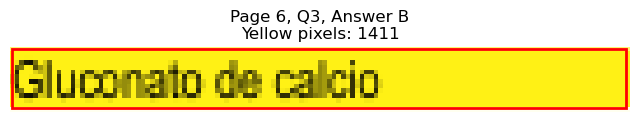

Page 6, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=377.7, y1=291.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 257
Page 6, Q3, C: Yellow percentage: 0.0%


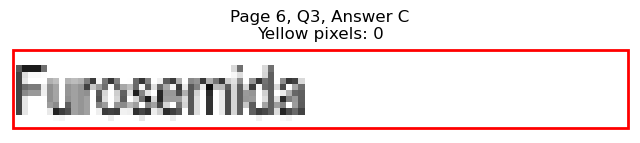

Page 6, Q3 - D: Detected box: x0=336.2, y0=291.4, x1=379.9, y1=304.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 226
Page 6, Q3, D: Yellow percentage: 0.0%


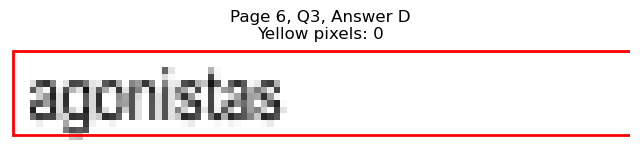


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=262.5, y1=354.6
Page 6, Q4, A: Yellow pixels: 2427
Page 6, Q4, A: Total non-white pixels: 3430
Page 6, Q4, A: Yellow percentage: 70.8%


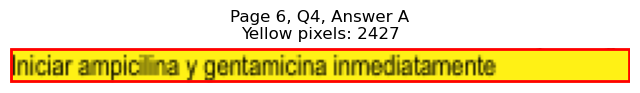

Page 6, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=262.5, y1=367.2
Page 6, Q4, B: Yellow pixels: 242
Page 6, Q4, B: Total non-white pixels: 1234
Page 6, Q4, B: Yellow percentage: 19.6%


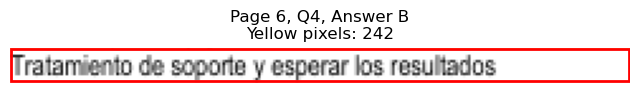

Page 6, Q4 - C: Detected box: x0=68.8, y0=367.1, x1=267.9, y1=379.8
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 987
Page 6, Q4, C: Yellow percentage: 0.0%


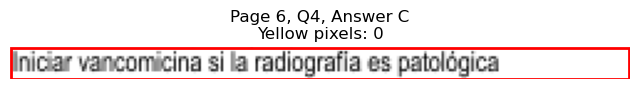

Page 6, Q4 - D: Detected box: x0=68.8, y0=379.7, x1=292.0, y1=392.4
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 1139
Page 6, Q4, D: Yellow percentage: 0.0%


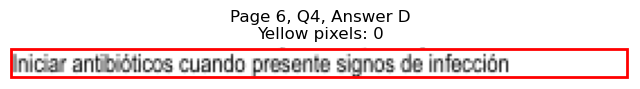


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=455.5, x1=144.5, y1=468.1
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 409
Page 6, Q5, A: Yellow percentage: 0.0%


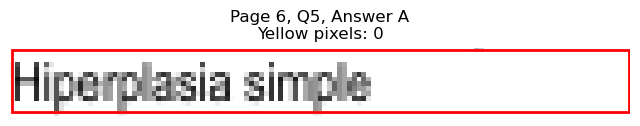

Page 6, Q5 - B: Detected box: x0=68.3, y0=468.1, x1=115.9, y1=480.7
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 251
Page 6, Q5, B: Yellow percentage: 0.0%


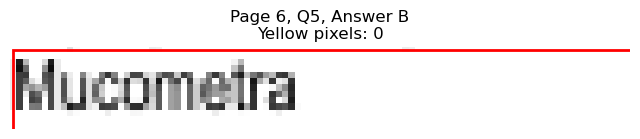

Page 6, Q5 - C: Detected box: x0=327.5, y0=455.5, x1=408.8, y1=468.1
Page 6, Q5, C: Yellow pixels: 1371
Page 6, Q5, C: Total non-white pixels: 1848
Page 6, Q5, C: Yellow percentage: 74.2%


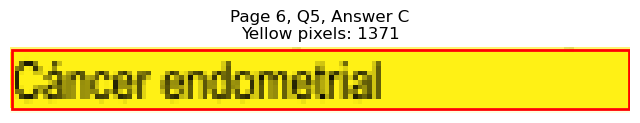

Page 6, Q5 - D: Detected box: x0=327.5, y0=468.1, x1=384.7, y1=480.7
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 401
Page 6, Q5, D: Yellow percentage: 0.0%


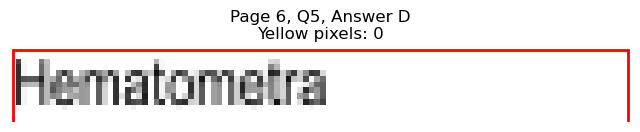


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=112.5, y1=531.2
Page 6, Q6, A: Yellow pixels: 95
Page 6, Q6, A: Total non-white pixels: 265
Page 6, Q6, A: Yellow percentage: 35.8%


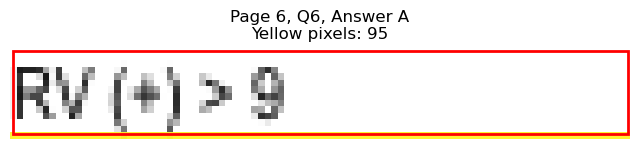

Page 6, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=117.7, y1=543.8
Page 6, Q6, B: Yellow pixels: 1158
Page 6, Q6, B: Total non-white pixels: 1300
Page 6, Q6, B: Yellow percentage: 89.1%


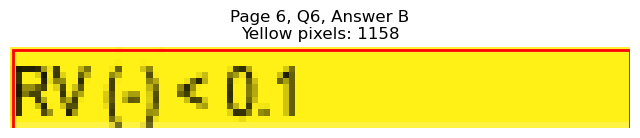

Page 6, Q6 - C: Detected box: x0=327.5, y0=518.6, x1=379.1, y1=531.2
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 206
Page 6, Q6, C: Yellow percentage: 0.0%


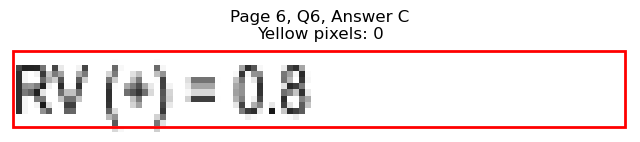

Page 6, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=374.5, y1=543.8
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 174
Page 6, Q6, D: Yellow percentage: 0.0%


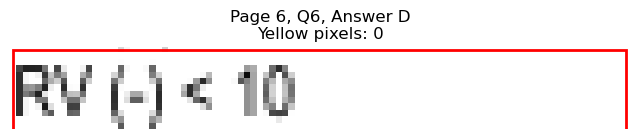


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=594.3, x1=144.0, y1=607.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 430
Page 6, Q7, A: Yellow percentage: 0.0%


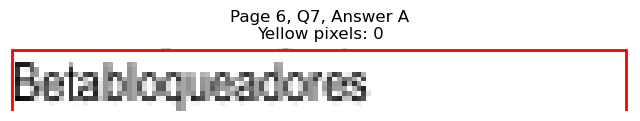

Page 6, Q7 - B: Detected box: x0=68.3, y0=606.9, x1=277.5, y1=619.6
Page 6, Q7, B: Yellow pixels: 14
Page 6, Q7, B: Total non-white pixels: 1121
Page 6, Q7, B: Yellow percentage: 1.2%


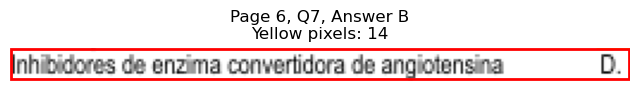

Page 6, Q7 - C: Detected box: x0=327.5, y0=594.3, x1=501.1, y1=607.0
Page 6, Q7, C: Yellow pixels: 2032
Page 6, Q7, C: Total non-white pixels: 2782
Page 6, Q7, C: Yellow percentage: 73.0%


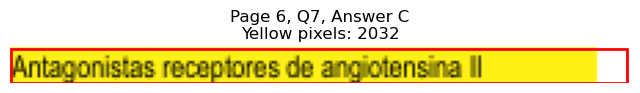

Page 6, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=470.1, y1=619.6
Page 6, Q7, D: Yellow pixels: 185
Page 6, Q7, D: Total non-white pixels: 904
Page 6, Q7, D: Yellow percentage: 20.5%


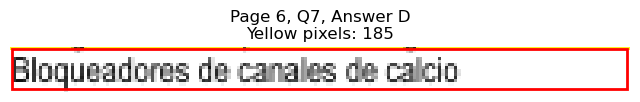


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=670.1, x1=175.3, y1=682.7
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 673
Page 6, Q8, A: Yellow percentage: 0.0%


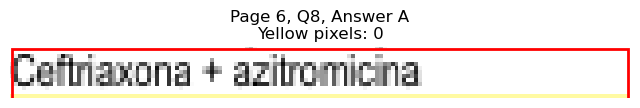

Page 6, Q8 - B: Detected box: x0=68.3, y0=682.7, x1=183.6, y1=695.3
Page 6, Q8, B: Yellow pixels: 1536
Page 6, Q8, B: Total non-white pixels: 2324
Page 6, Q8, B: Yellow percentage: 66.1%


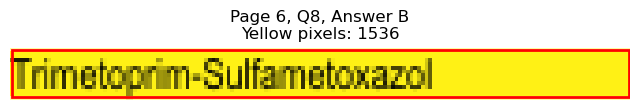

Page 6, Q8 - C: Detected box: x0=327.5, y0=670.1, x1=380.2, y1=682.7
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 279
Page 6, Q8, C: Yellow percentage: 0.0%


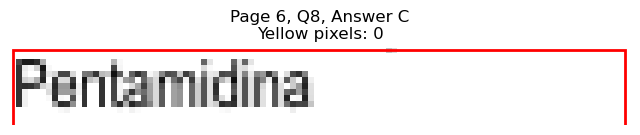

Page 6, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=436.6, y1=695.3
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 550
Page 6, Q8, D: Yellow percentage: 0.0%


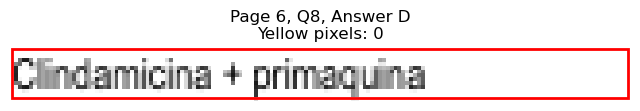


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=745.8, x1=120.0, y1=758.4
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 248
Page 6, Q9, A: Yellow percentage: 0.0%


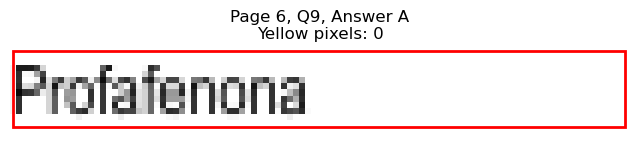

Page 6, Q9 - B: Detected box: x0=68.3, y0=758.5, x1=116.4, y1=771.2
Page 6, Q9, B: Yellow pixels: 1091
Page 6, Q9, B: Total non-white pixels: 1386
Page 6, Q9, B: Yellow percentage: 78.7%


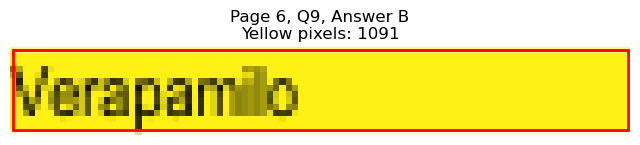

Page 6, Q9 - C: Detected box: x0=327.5, y0=745.8, x1=378.7, y1=758.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 258
Page 6, Q9, C: Yellow percentage: 0.0%


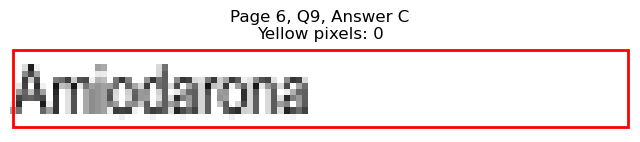

Page 6, Q9 - D: Detected box: x0=327.5, y0=758.5, x1=371.8, y1=771.2
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 225
Page 6, Q9, D: Yellow percentage: 0.0%


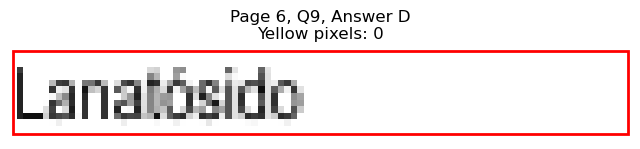


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=162.0, y1=102.1
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 452
Page 7, Q1, A: Yellow percentage: 0.0%


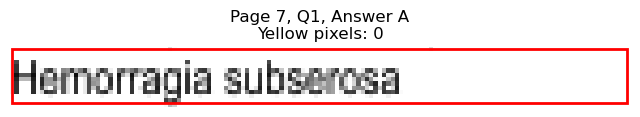

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=151.6, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 423
Page 7, Q1, B: Yellow percentage: 0.0%


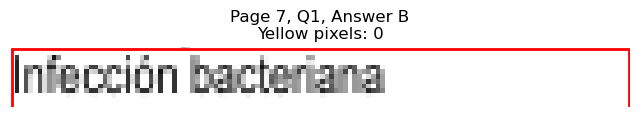

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=380.7, y1=102.1
Page 7, Q1, C: Yellow pixels: 104
Page 7, Q1, C: Total non-white pixels: 398
Page 7, Q1, C: Yellow percentage: 26.1%


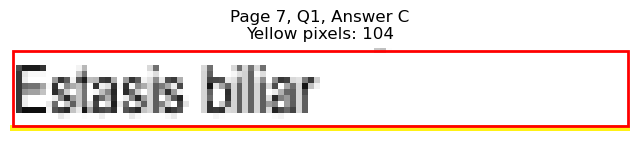

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=420.8, y1=114.7
Page 7, Q1, D: Yellow pixels: 1540
Page 7, Q1, D: Total non-white pixels: 1872
Page 7, Q1, D: Yellow percentage: 82.3%


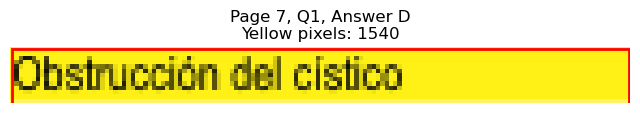


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=106.9, y1=165.2
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 182
Page 7, Q2, A: Yellow percentage: 0.0%


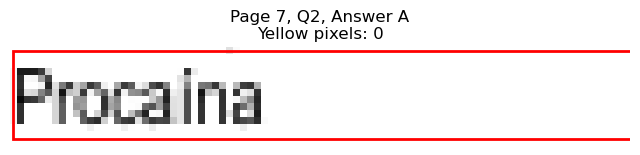

Page 7, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=127.5, y1=177.8
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 301
Page 7, Q2, B: Yellow percentage: 0.0%


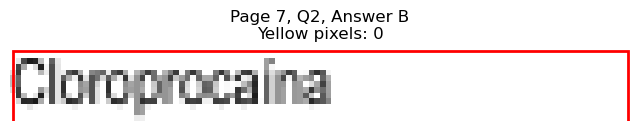

Page 7, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=369.2, y1=165.2
Page 7, Q2, C: Yellow pixels: 93
Page 7, Q2, C: Total non-white pixels: 272
Page 7, Q2, C: Yellow percentage: 34.2%


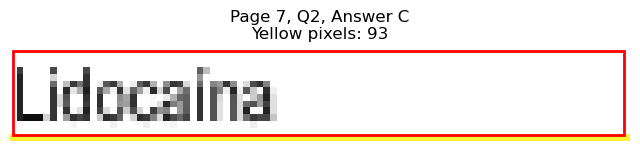

Page 7, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=379.7, y1=177.8
Page 7, Q2, D: Yellow pixels: 1142
Page 7, Q2, D: Total non-white pixels: 1339
Page 7, Q2, D: Yellow percentage: 85.3%


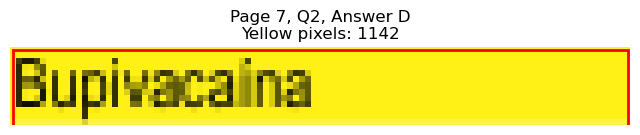


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=150.0, y1=228.3
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 391
Page 7, Q3, A: Yellow percentage: 0.0%


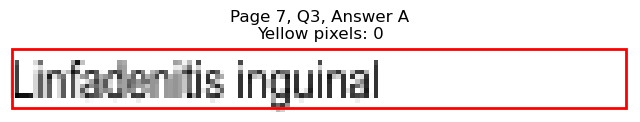

Page 7, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=180.6, y1=240.9
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 534
Page 7, Q3, B: Yellow percentage: 0.0%


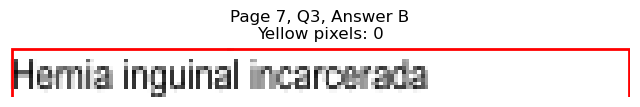

Page 7, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=389.2, y1=228.3
Page 7, Q3, C: Yellow pixels: 113
Page 7, Q3, C: Total non-white pixels: 432
Page 7, Q3, C: Yellow percentage: 26.2%


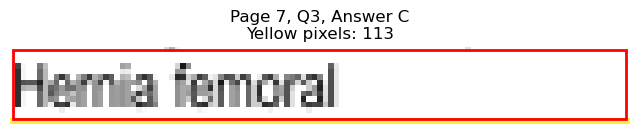

Page 7, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=421.9, y1=240.9
Page 7, Q3, D: Yellow pixels: 1505
Page 7, Q3, D: Total non-white pixels: 1885
Page 7, Q3, D: Yellow percentage: 79.8%


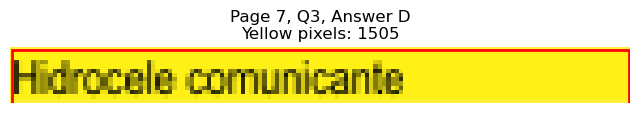


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=144.0, y1=291.5
Page 7, Q4, A: Yellow pixels: 1306
Page 7, Q4, A: Total non-white pixels: 1778
Page 7, Q4, A: Yellow percentage: 73.5%


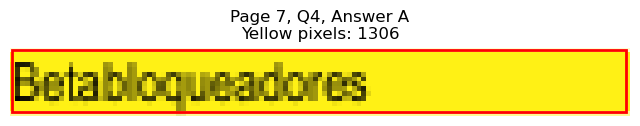

Page 7, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=144.0, y1=304.1
Page 7, Q4, B: Yellow pixels: 127
Page 7, Q4, B: Total non-white pixels: 505
Page 7, Q4, B: Yellow percentage: 25.1%


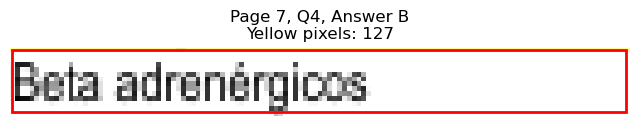

Page 7, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=371.2, y1=291.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 264
Page 7, Q4, C: Yellow percentage: 0.0%


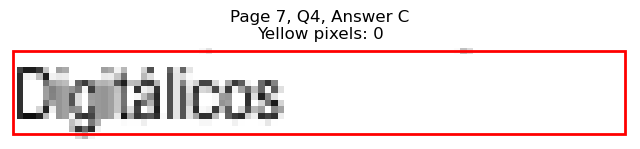

Page 7, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=408.8, y1=304.1
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 416
Page 7, Q4, D: Yellow percentage: 0.0%


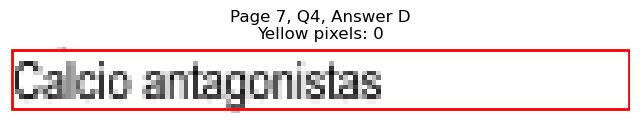


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=133.9, y1=392.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 323
Page 7, Q5, A: Yellow percentage: 0.0%


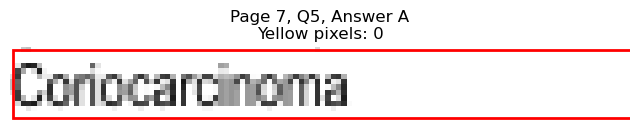

Page 7, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=136.5, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 331
Page 7, Q5, B: Yellow percentage: 0.0%


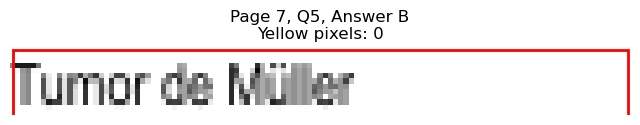

Page 7, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=395.2, y1=392.4
Page 7, Q5, C: Yellow pixels: 1180
Page 7, Q5, C: Total non-white pixels: 1666
Page 7, Q5, C: Yellow percentage: 70.8%


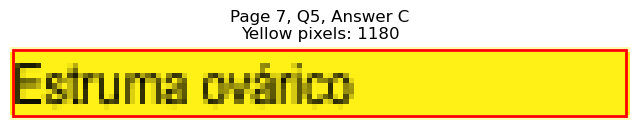

Page 7, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=397.7, y1=405.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 452
Page 7, Q5, D: Yellow percentage: 0.0%


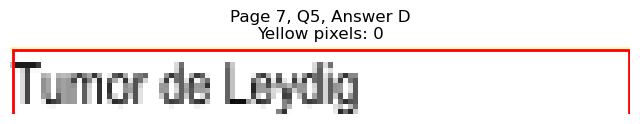


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=107.4, y1=455.5
Page 7, Q6, A: Yellow pixels: 90
Page 7, Q6, A: Total non-white pixels: 319
Page 7, Q6, A: Yellow percentage: 28.2%


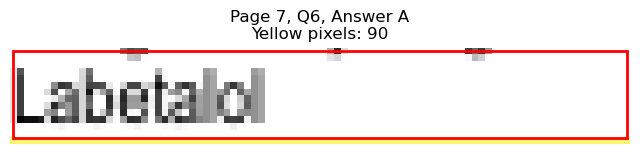

Page 7, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=113.4, y1=468.1
Page 7, Q6, B: Yellow pixels: 1058
Page 7, Q6, B: Total non-white pixels: 1344
Page 7, Q6, B: Yellow percentage: 78.7%


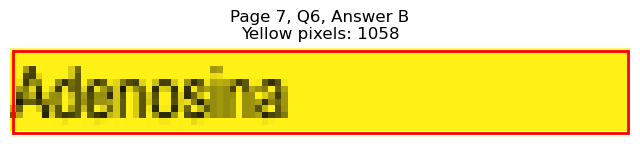

Page 7, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=374.2, y1=455.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 229
Page 7, Q6, C: Yellow percentage: 0.0%


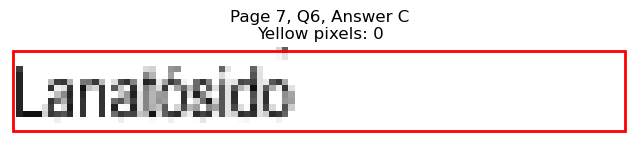

Page 7, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=375.7, y1=468.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 239
Page 7, Q6, D: Yellow percentage: 0.0%


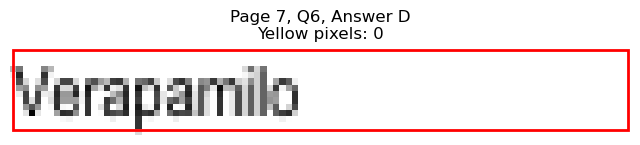


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=157.1, y1=543.8
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 572
Page 7, Q7, A: Yellow percentage: 0.0%


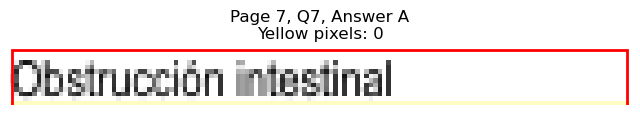

Page 7, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=167.1, y1=556.4
Page 7, Q7, B: Yellow pixels: 1557
Page 7, Q7, B: Total non-white pixels: 2100
Page 7, Q7, B: Yellow percentage: 74.1%


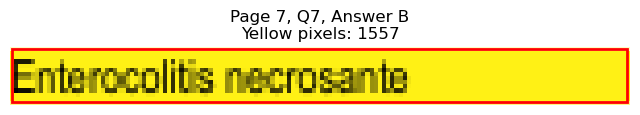

Page 7, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=394.3, y1=543.8
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 346
Page 7, Q7, C: Yellow percentage: 0.0%


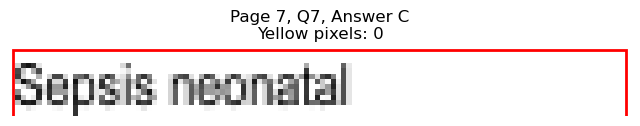

Page 7, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=397.7, y1=556.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 376
Page 7, Q7, D: Yellow percentage: 0.0%


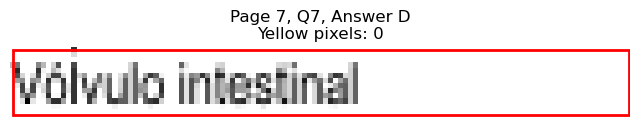


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=128.4, y1=619.6
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 323
Page 7, Q8, A: Yellow percentage: 0.0%


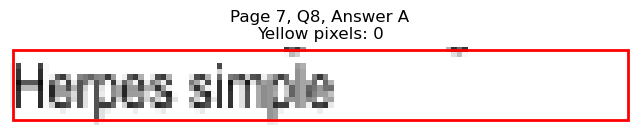

Page 7, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=153.5, y1=632.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 461
Page 7, Q8, B: Yellow percentage: 0.0%


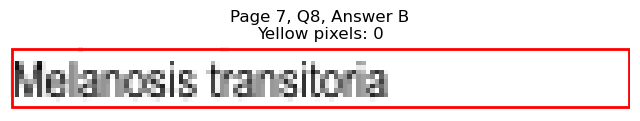

Page 7, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=387.2, y1=619.6
Page 7, Q8, C: Yellow pixels: 1219
Page 7, Q8, C: Total non-white pixels: 1554
Page 7, Q8, C: Yellow percentage: 78.4%


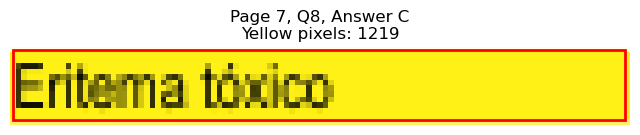

Page 7, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=376.7, y1=632.3
Page 7, Q8, D: Yellow pixels: 100
Page 7, Q8, D: Total non-white pixels: 374
Page 7, Q8, D: Yellow percentage: 26.7%


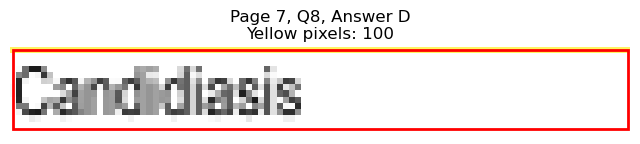


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=179.7, y1=695.3
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 525
Page 7, Q9, A: Yellow percentage: 0.0%


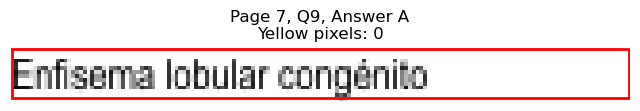

Page 7, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=140.2, y1=708.0
Page 7, Q9, B: Yellow pixels: 1305
Page 7, Q9, B: Total non-white pixels: 1602
Page 7, Q9, B: Yellow percentage: 81.5%


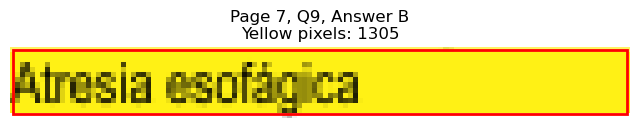

Page 7, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=410.9, y1=695.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 429
Page 7, Q9, C: Yellow percentage: 0.0%


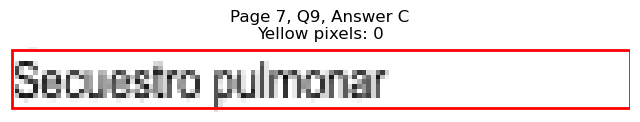

Page 7, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=415.9, y1=708.0
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 474
Page 7, Q9, D: Yellow percentage: 0.0%


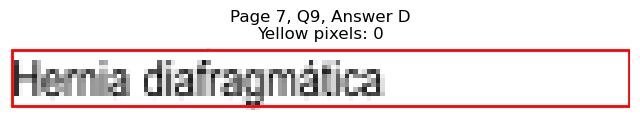


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=157.6, y1=139.9
Page 8, Q1, A: Yellow pixels: 1483
Page 8, Q1, A: Total non-white pixels: 1820
Page 8, Q1, A: Yellow percentage: 81.5%


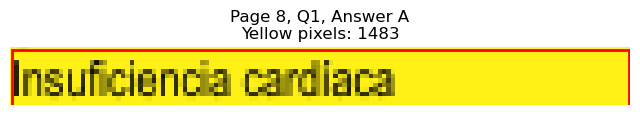

Page 8, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=136.0, y1=152.6
Page 8, Q1, B: Yellow pixels: 118
Page 8, Q1, B: Total non-white pixels: 454
Page 8, Q1, B: Yellow percentage: 26.0%


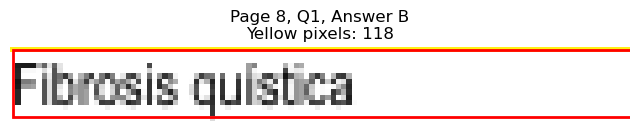

Page 8, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=407.8, y1=139.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 422
Page 8, Q1, C: Yellow percentage: 0.0%


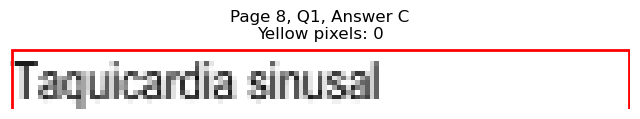

Page 8, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=412.7, y1=152.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 443
Page 8, Q1, D: Yellow percentage: 0.0%


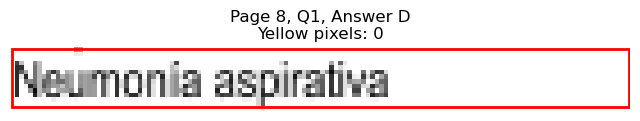


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=143.5, y1=190.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 364
Page 8, Q2, A: Yellow percentage: 0.0%


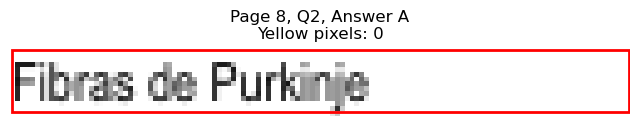

Page 8, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=115.0, y1=203.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 225
Page 8, Q2, B: Yellow percentage: 0.0%


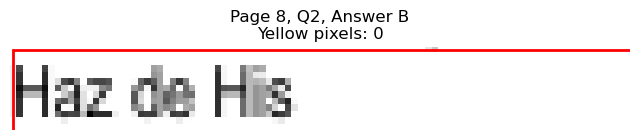

Page 8, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=412.3, y1=190.4
Page 8, Q2, C: Yellow pixels: 1282
Page 8, Q2, C: Total non-white pixels: 1904
Page 8, Q2, C: Yellow percentage: 67.3%


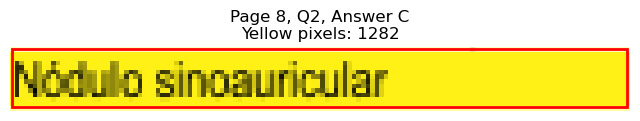

Page 8, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=420.3, y1=203.0
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 635
Page 8, Q2, D: Yellow percentage: 0.0%


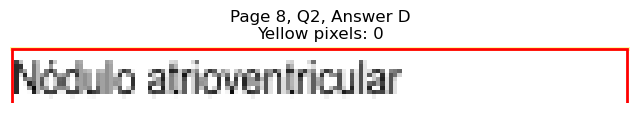


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=133.9, y1=266.1
Page 8, Q3, A: Yellow pixels: 1235
Page 8, Q3, A: Total non-white pixels: 1624
Page 8, Q3, A: Yellow percentage: 76.0%


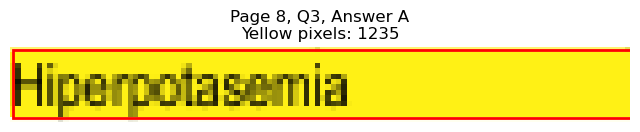

Page 8, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=126.5, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 422
Page 8, Q3, B: Yellow percentage: 0.0%


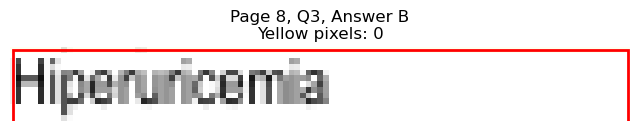

Page 8, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=387.2, y1=266.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 327
Page 8, Q3, C: Yellow percentage: 0.0%


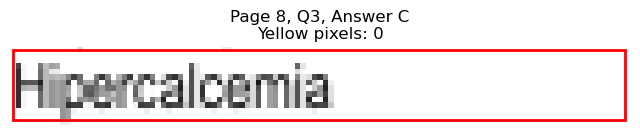

Page 8, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=386.7, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 312
Page 8, Q3, D: Yellow percentage: 0.0%


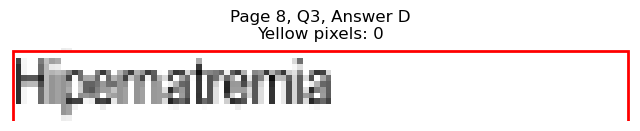


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=175.1, y1=341.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 507
Page 8, Q4, A: Yellow percentage: 0.0%


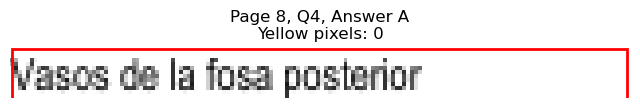

Page 8, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=166.6, y1=354.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 502
Page 8, Q4, B: Yellow percentage: 0.0%


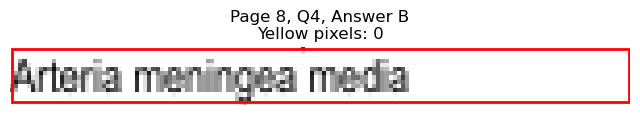

Page 8, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=466.4, y1=341.9
Page 8, Q4, C: Yellow pixels: 1949
Page 8, Q4, C: Total non-white pixels: 2470
Page 8, Q4, C: Yellow percentage: 78.9%


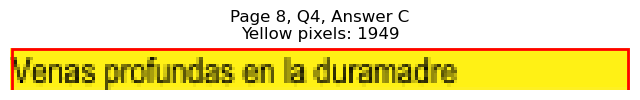

Page 8, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=436.9, y1=354.6
Page 8, Q4, D: Yellow pixels: 159
Page 8, Q4, D: Total non-white pixels: 731
Page 8, Q4, D: Yellow percentage: 21.8%


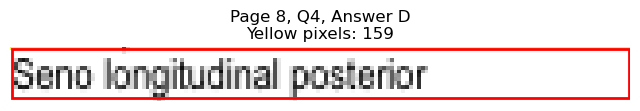


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=154.6, y1=417.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 469
Page 8, Q5, A: Yellow percentage: 0.0%


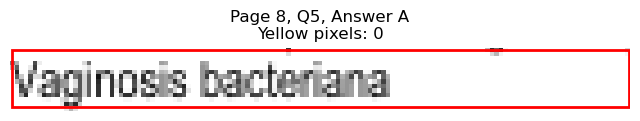

Page 8, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=170.1, y1=430.3
Page 8, Q5, B: Yellow pixels: 1428
Page 8, Q5, B: Total non-white pixels: 2142
Page 8, Q5, B: Yellow percentage: 66.7%


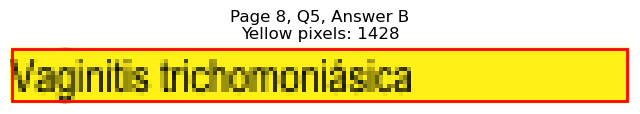

Page 8, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=412.3, y1=417.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 461
Page 8, Q5, C: Yellow percentage: 0.0%


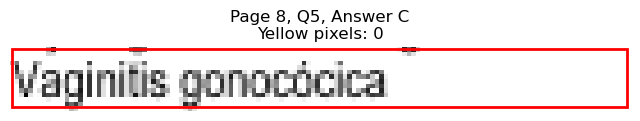

Page 8, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=414.3, y1=430.3
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 471
Page 8, Q5, D: Yellow percentage: 0.0%


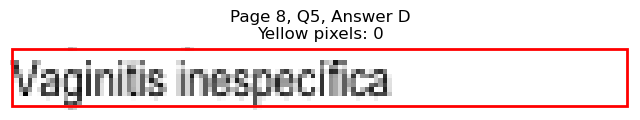


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=181.7, y1=493.4
Page 8, Q6, A: Yellow pixels: 1536
Page 8, Q6, A: Total non-white pixels: 2296
Page 8, Q6, A: Yellow percentage: 66.9%


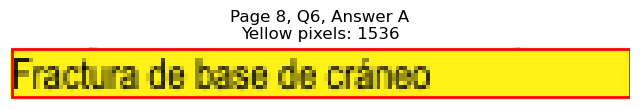

Page 8, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=152.1, y1=506.0
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 519
Page 8, Q6, B: Yellow percentage: 0.0%


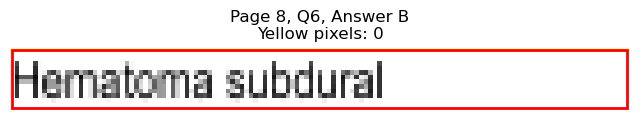

Page 8, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=440.3, y1=493.4
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 556
Page 8, Q6, C: Yellow percentage: 0.0%


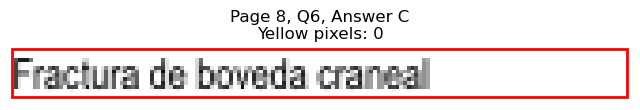

Page 8, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=408.8, y1=506.0
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 423
Page 8, Q6, D: Yellow percentage: 0.0%


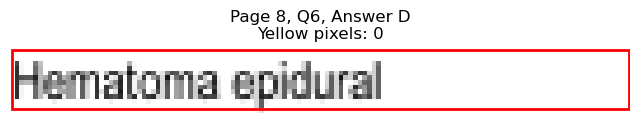


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=223.8, y1=543.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 797
Page 8, Q7, A: Yellow percentage: 0.0%


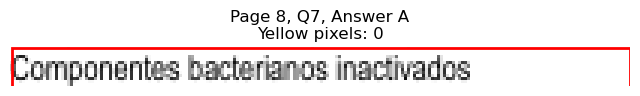

Page 8, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=159.1, y1=556.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 456
Page 8, Q7, B: Yellow percentage: 0.0%


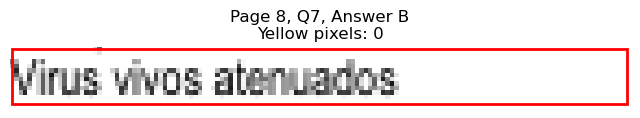

Page 8, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=421.4, y1=543.8
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 584
Page 8, Q7, C: Yellow percentage: 0.0%


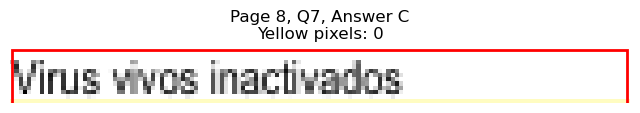

Page 8, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=460.9, y1=556.4
Page 8, Q7, D: Yellow pixels: 1866
Page 8, Q7, D: Total non-white pixels: 2576
Page 8, Q7, D: Yellow percentage: 72.4%


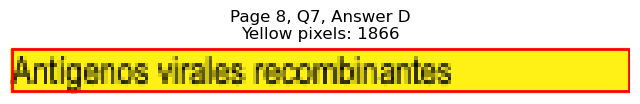


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=127.9, y1=607.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 295
Page 8, Q8, A: Yellow percentage: 0.0%


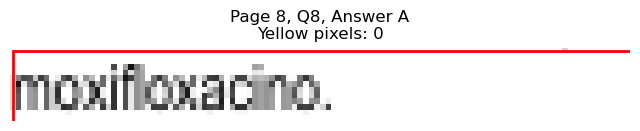

Page 8, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=124.5, y1=619.6
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 276
Page 8, Q8, B: Yellow percentage: 0.0%


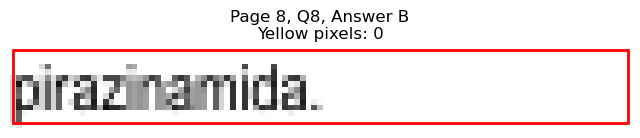

Page 8, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=376.1, y1=607.0
Page 8, Q8, C: Yellow pixels: 1117
Page 8, Q8, C: Total non-white pixels: 1300
Page 8, Q8, C: Yellow percentage: 85.9%


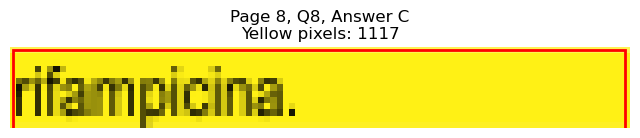

Page 8, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=372.2, y1=619.6
Page 8, Q8, D: Yellow pixels: 95
Page 8, Q8, D: Total non-white pixels: 324
Page 8, Q8, D: Yellow percentage: 29.3%


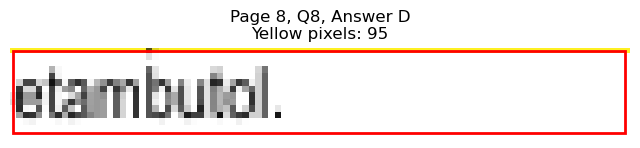


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=121.0, y1=695.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 258
Page 8, Q9, A: Yellow percentage: 0.0%


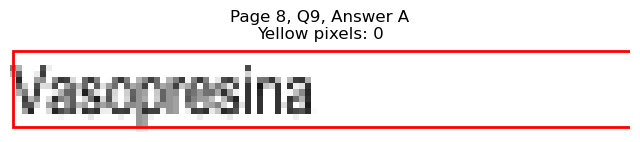

Page 8, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=119.4, y1=708.0
Page 8, Q9, B: Yellow pixels: 1121
Page 8, Q9, B: Total non-white pixels: 1326
Page 8, Q9, B: Yellow percentage: 84.5%


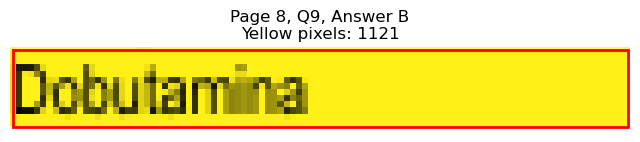

Page 8, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=380.7, y1=695.3
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 270
Page 8, Q9, C: Yellow percentage: 0.0%


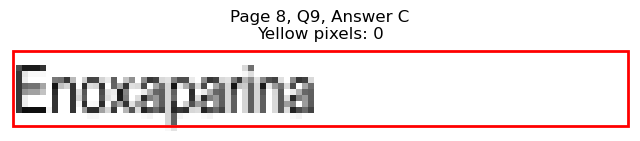

Page 8, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=373.1, y1=708.0
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 226
Page 8, Q9, D: Yellow percentage: 0.0%


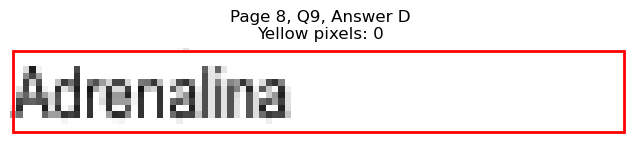


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=140.1, y1=758.4
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 360
Page 8, Q10, A: Yellow percentage: 0.0%


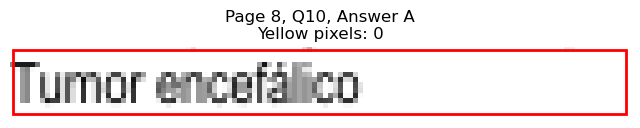

Page 8, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=119.9, y1=771.2
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 271
Page 8, Q10, B: Yellow percentage: 0.0%


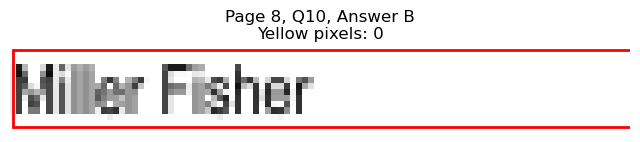

Page 8, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=393.8, y1=758.4
Page 8, Q10, C: Yellow pixels: 1239
Page 8, Q10, C: Total non-white pixels: 1638
Page 8, Q10, C: Yellow percentage: 75.6%


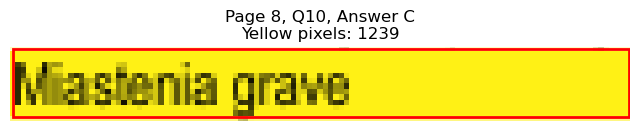

Page 8, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=375.2, y1=771.2
Page 8, Q10, D: Yellow pixels: 97
Page 8, Q10, D: Total non-white pixels: 351
Page 8, Q10, D: Yellow percentage: 27.6%


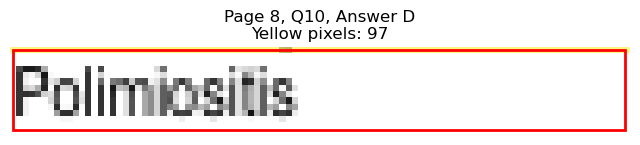


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=167.1, y1=139.9
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 501
Page 9, Q1, A: Yellow percentage: 0.0%


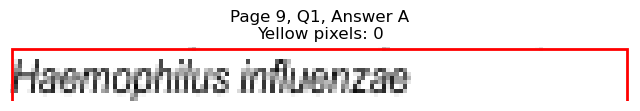

Page 9, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=180.1, y1=152.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 561
Page 9, Q1, B: Yellow percentage: 0.0%


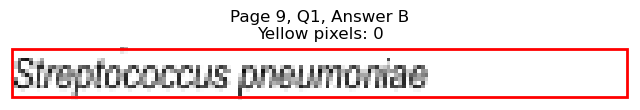

Page 9, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=430.4, y1=139.9
Page 9, Q1, C: Yellow pixels: 1595
Page 9, Q1, C: Total non-white pixels: 2002
Page 9, Q1, C: Yellow percentage: 79.7%


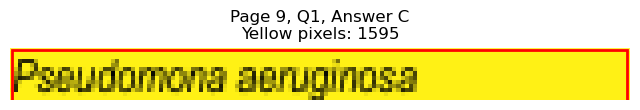

Page 9, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=425.3, y1=152.6
Page 9, Q1, D: Yellow pixels: 145
Page 9, Q1, D: Total non-white pixels: 665
Page 9, Q1, D: Yellow percentage: 21.8%


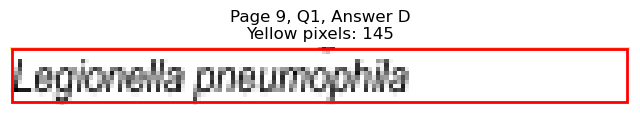


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=113.9, y1=190.4
Page 9, Q2, A: Yellow pixels: 96
Page 9, Q2, A: Total non-white pixels: 338
Page 9, Q2, A: Yellow percentage: 28.4%


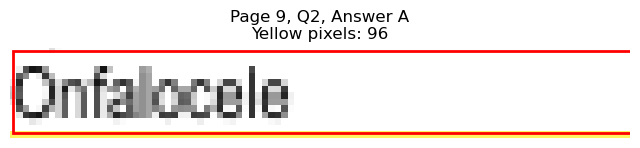

Page 9, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=131.1, y1=203.0
Page 9, Q2, B: Yellow pixels: 1239
Page 9, Q2, B: Total non-white pixels: 1482
Page 9, Q2, B: Yellow percentage: 83.6%


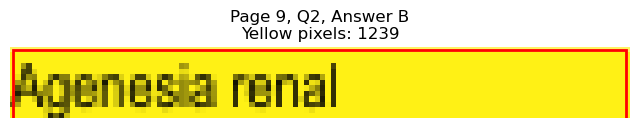

Page 9, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=416.3, y1=190.4
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 449
Page 9, Q2, C: Yellow percentage: 0.0%


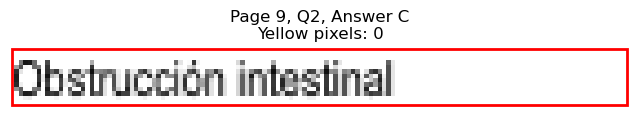

Page 9, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=405.3, y1=203.0
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 394
Page 9, Q2, D: Yellow percentage: 0.0%


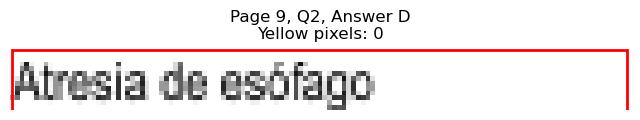


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=148.1, y1=291.5
Page 9, Q3, A: Yellow pixels: 1385
Page 9, Q3, A: Total non-white pixels: 1834
Page 9, Q3, A: Yellow percentage: 75.5%


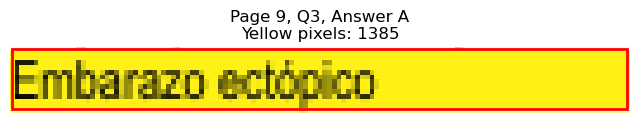

Page 9, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=147.0, y1=304.1
Page 9, Q3, B: Yellow pixels: 130
Page 9, Q3, B: Total non-white pixels: 533
Page 9, Q3, B: Yellow percentage: 24.4%


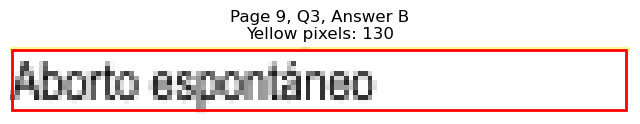

Page 9, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=387.8, y1=291.5
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 295
Page 9, Q3, C: Yellow percentage: 0.0%


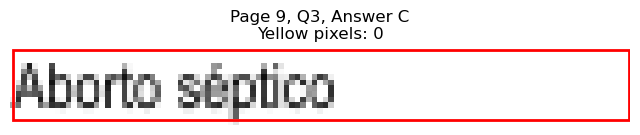

Page 9, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=430.9, y1=304.1
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 506
Page 9, Q3, D: Yellow percentage: 0.0%


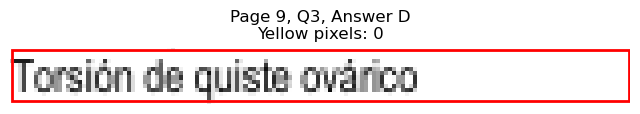


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=150.0, y1=367.2
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 428
Page 9, Q4, A: Yellow percentage: 0.0%


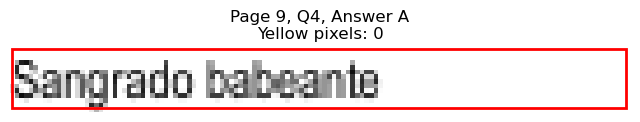

Page 9, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=142.0, y1=379.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 366
Page 9, Q4, B: Yellow percentage: 0.0%


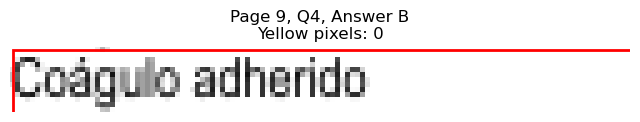

Page 9, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=433.4, y1=367.2
Page 9, Q4, C: Yellow pixels: 157
Page 9, Q4, C: Total non-white pixels: 681
Page 9, Q4, C: Yellow percentage: 23.1%


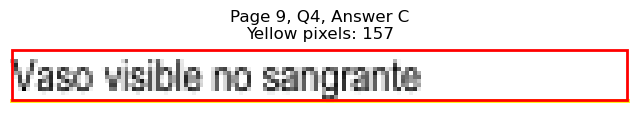

Page 9, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=436.4, y1=379.8
Page 9, Q4, D: Yellow pixels: 1621
Page 9, Q4, D: Total non-white pixels: 2080
Page 9, Q4, D: Yellow percentage: 77.9%


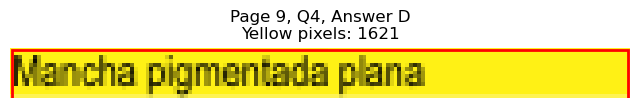


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=165.6, y1=455.5
Page 9, Q5, A: Yellow pixels: 148
Page 9, Q5, A: Total non-white pixels: 627
Page 9, Q5, A: Yellow percentage: 23.6%


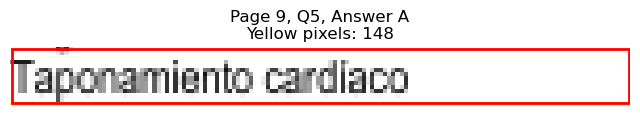

Page 9, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=159.0, y1=468.1
Page 9, Q5, B: Yellow pixels: 1506
Page 9, Q5, B: Total non-white pixels: 1988
Page 9, Q5, B: Yellow percentage: 75.8%


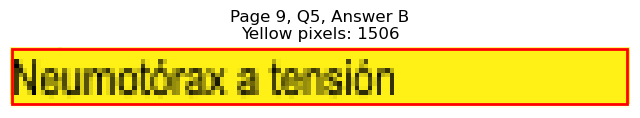

Page 9, Q5 - C: Detected box: x0=327.5, y0=442.8, x1=457.9, y1=455.5
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 699
Page 9, Q5, C: Yellow percentage: 0.0%


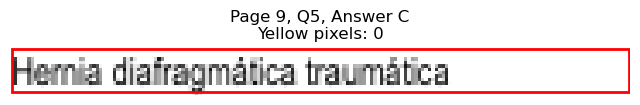

Page 9, Q5 - D: Detected box: x0=327.5, y0=455.5, x1=389.7, y1=468.1
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 314
Page 9, Q5, D: Yellow percentage: 0.0%


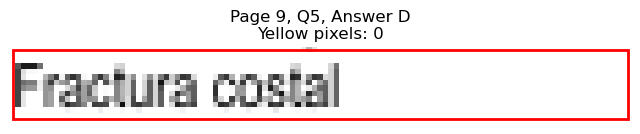


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=100.0, y1=518.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 160
Page 9, Q6, A: Yellow percentage: 0.0%


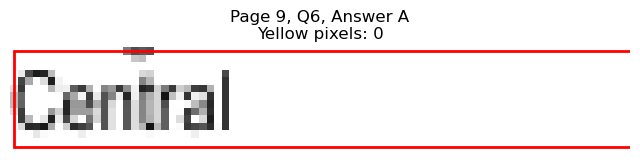

Page 9, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=109.0, y1=531.2
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 216
Page 9, Q6, B: Yellow percentage: 0.0%


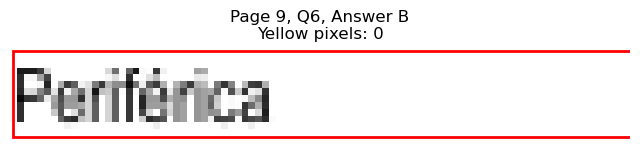

Page 9, Q6 - C: Detected box: x0=327.5, y0=506.0, x1=371.8, y1=518.6
Page 9, Q6, C: Yellow pixels: 95
Page 9, Q6, C: Total non-white pixels: 306
Page 9, Q6, C: Yellow percentage: 31.0%


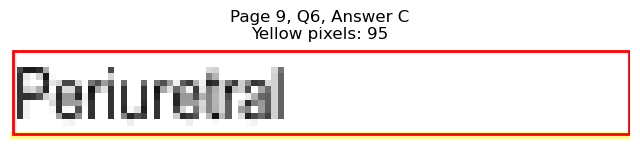

Page 9, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=378.8, y1=531.2
Page 9, Q6, D: Yellow pixels: 1122
Page 9, Q6, D: Total non-white pixels: 1428
Page 9, Q6, D: Yellow percentage: 78.6%


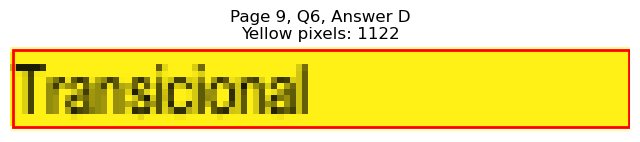


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=93.4, y1=581.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 192
Page 9, Q7, A: Yellow percentage: 0.0%


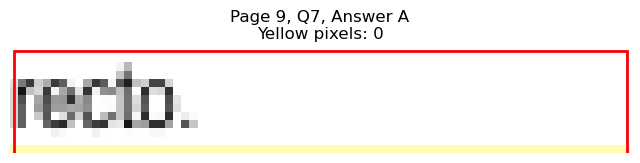

Page 9, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=93.9, y1=594.4
Page 9, Q7, B: Yellow pixels: 819
Page 9, Q7, B: Total non-white pixels: 1064
Page 9, Q7, B: Yellow percentage: 77.0%


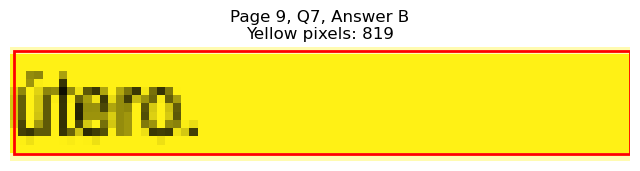

Page 9, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=356.1, y1=581.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 153
Page 9, Q7, C: Yellow percentage: 0.0%


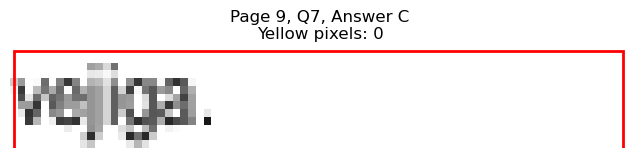

Page 9, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=356.1, y1=594.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 125
Page 9, Q7, D: Yellow percentage: 0.0%


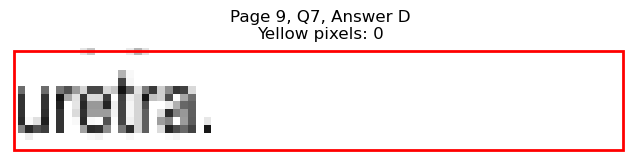


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=175.3, y1=657.5
Page 9, Q8, A: Yellow pixels: 1657
Page 9, Q8, A: Total non-white pixels: 2212
Page 9, Q8, A: Yellow percentage: 74.9%


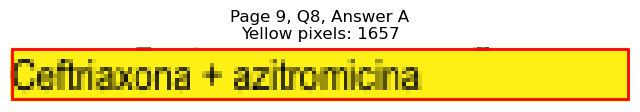

Page 9, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=183.9, y1=670.1
Page 9, Q8, B: Yellow pixels: 166
Page 9, Q8, B: Total non-white pixels: 722
Page 9, Q8, B: Yellow percentage: 23.0%


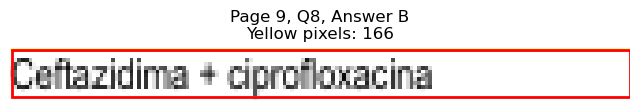

Page 9, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=437.6, y1=657.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 530
Page 9, Q8, C: Yellow percentage: 0.0%


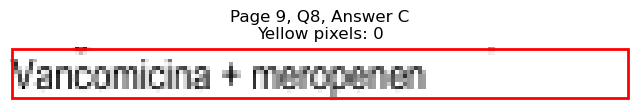

Page 9, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=427.1, y1=670.1
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 447
Page 9, Q8, D: Yellow percentage: 0.0%


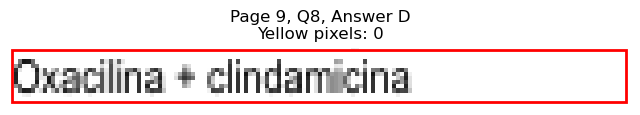


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=171.1, y1=708.0
Page 9, Q9, A: Yellow pixels: 154
Page 9, Q9, A: Total non-white pixels: 847
Page 9, Q9, A: Yellow percentage: 18.2%


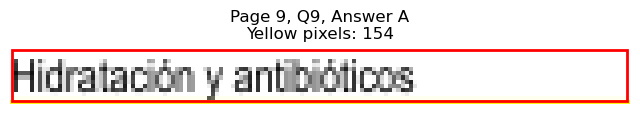

Page 9, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=162.1, y1=720.6
Page 9, Q9, B: Yellow pixels: 1489
Page 9, Q9, B: Total non-white pixels: 2030
Page 9, Q9, B: Yellow percentage: 73.3%


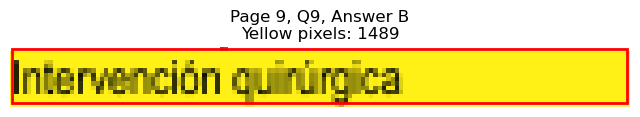

Page 9, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=380.7, y1=708.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 259
Page 9, Q9, C: Yellow percentage: 0.0%


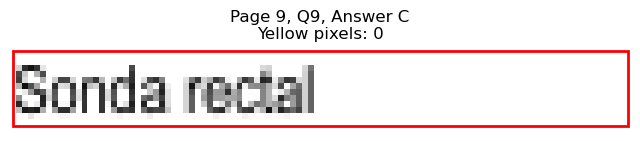

Page 9, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=409.9, y1=720.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 414
Page 9, Q9, D: Yellow percentage: 0.0%


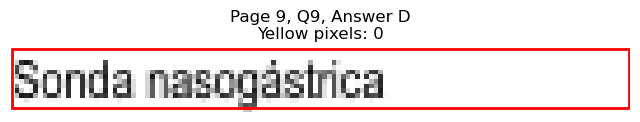


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=156.6, y1=139.9
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 456
Page 10, Q1, A: Yellow percentage: 0.0%


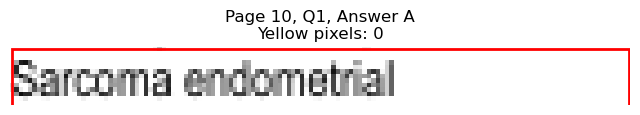

Page 10, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=146.5, y1=152.6
Page 10, Q1, B: Yellow pixels: 1366
Page 10, Q1, B: Total non-white pixels: 1806
Page 10, Q1, B: Yellow percentage: 75.6%


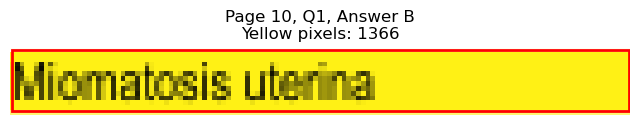

Page 10, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=404.8, y1=139.9
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 396
Page 10, Q1, C: Yellow percentage: 0.0%


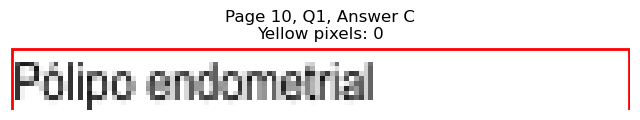

Page 10, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=381.7, y1=152.6
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 267
Page 10, Q1, D: Yellow percentage: 0.0%


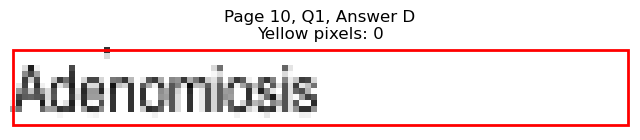


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=134.1, y1=203.0
Page 10, Q2, A: Yellow pixels: 1279
Page 10, Q2, A: Total non-white pixels: 1521
Page 10, Q2, A: Yellow percentage: 84.1%


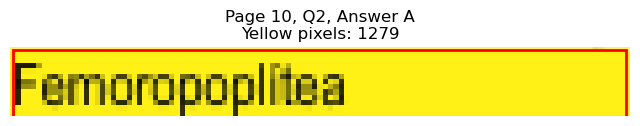

Page 10, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=130.0, y1=215.6
Page 10, Q2, B: Yellow pixels: 110
Page 10, Q2, B: Total non-white pixels: 423
Page 10, Q2, B: Yellow percentage: 26.0%


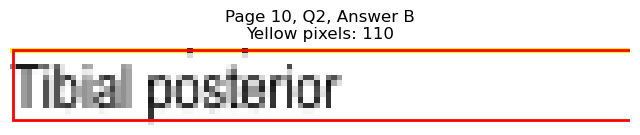

Page 10, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=372.7, y1=203.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 230
Page 10, Q2, C: Yellow percentage: 0.0%


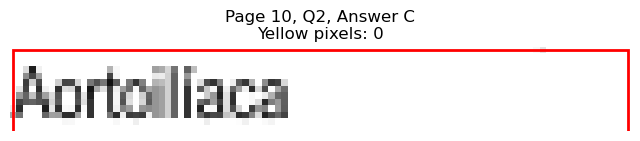

Page 10, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=385.3, y1=215.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 286
Page 10, Q2, D: Yellow percentage: 0.0%


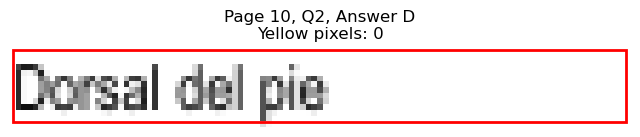


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=140.1, y1=253.5
Page 10, Q3, A: Yellow pixels: 1311
Page 10, Q3, A: Total non-white pixels: 1722
Page 10, Q3, A: Yellow percentage: 76.1%


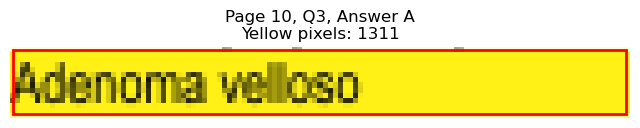

Page 10, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=139.6, y1=266.1
Page 10, Q3, B: Yellow pixels: 122
Page 10, Q3, B: Total non-white pixels: 492
Page 10, Q3, B: Yellow percentage: 24.8%


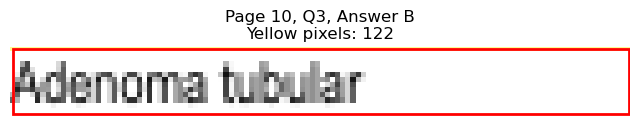

Page 10, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=414.8, y1=253.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 467
Page 10, Q3, C: Yellow percentage: 0.0%


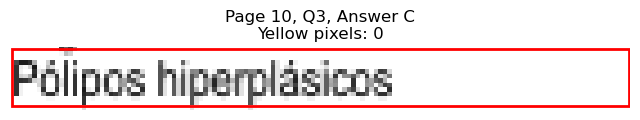

Page 10, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=381.7, y1=266.1
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 271
Page 10, Q3, D: Yellow percentage: 0.0%


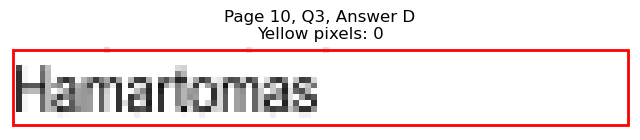


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=135.5, y1=316.7
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 365
Page 10, Q4, A: Yellow percentage: 0.0%


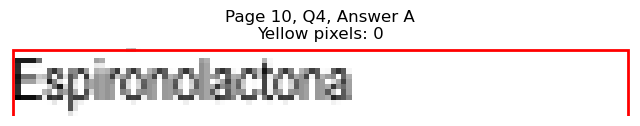

Page 10, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=116.4, y1=329.3
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 238
Page 10, Q4, B: Yellow percentage: 0.0%


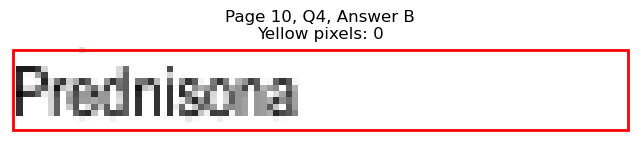

Page 10, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=379.7, y1=316.7
Page 10, Q4, C: Yellow pixels: 1145
Page 10, Q4, C: Total non-white pixels: 1339
Page 10, Q4, C: Yellow percentage: 85.5%


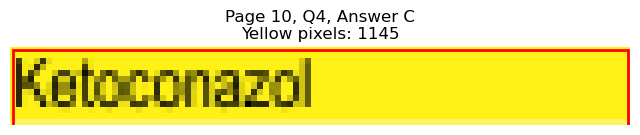

Page 10, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=373.7, y1=329.3
Page 10, Q4, D: Yellow pixels: 97
Page 10, Q4, D: Total non-white pixels: 326
Page 10, Q4, D: Yellow percentage: 29.8%


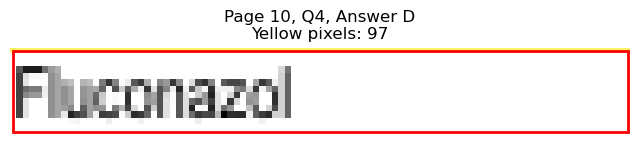


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=76.8, y1=392.4
Page 10, Q5, A: Yellow pixels: 686
Page 10, Q5, A: Total non-white pixels: 826
Page 10, Q5, A: Yellow percentage: 83.1%


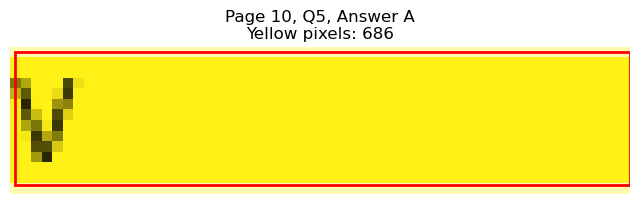

Page 10, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=76.8, y1=405.0
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 90
Page 10, Q5, B: Yellow percentage: 0.0%


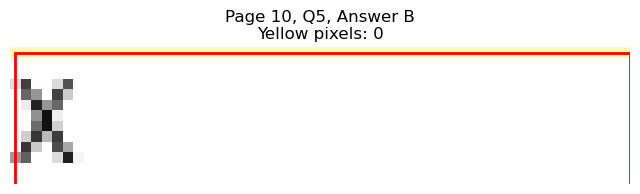

Page 10, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=338.6, y1=392.4
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 48
Page 10, Q5, C: Yellow percentage: 0.0%


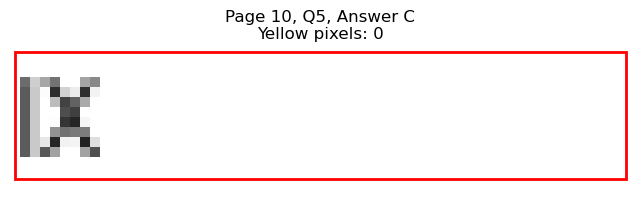

Page 10, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=341.1, y1=405.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 61
Page 10, Q5, D: Yellow percentage: 0.0%


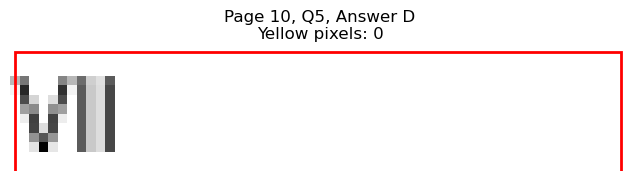


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=65.2, y1=468.1
Page 10, Q6, A: Yellow pixels: 728
Page 10, Q6, A: Total non-white pixels: 840
Page 10, Q6, A: Yellow percentage: 86.7%


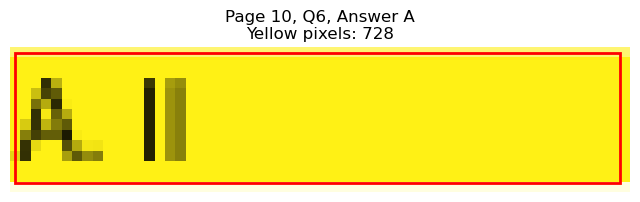

Page 10, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=89.4, y1=480.7
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 182
Page 10, Q6, B: Yellow percentage: 0.0%


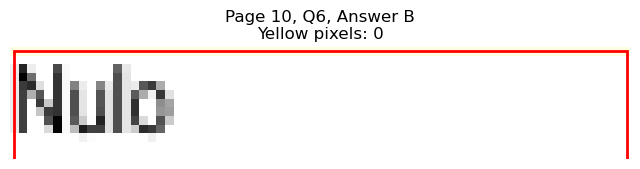

Page 10, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=345.7, y1=468.1
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 85
Page 10, Q6, C: Yellow percentage: 0.0%


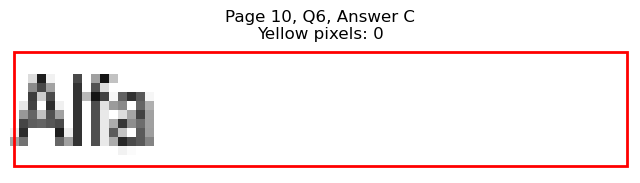

Page 10, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=324.4, y1=480.7
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 56
Page 10, Q6, D: Yellow percentage: 0.0%


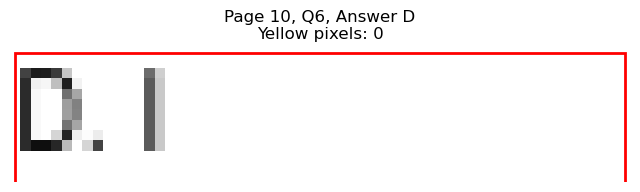


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=112.5, y1=531.2
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 215
Page 10, Q7, A: Yellow percentage: 0.0%


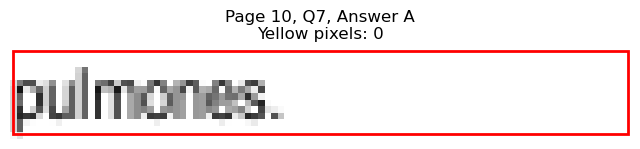

Page 10, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=103.9, y1=543.8
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 175
Page 10, Q7, B: Yellow percentage: 0.0%


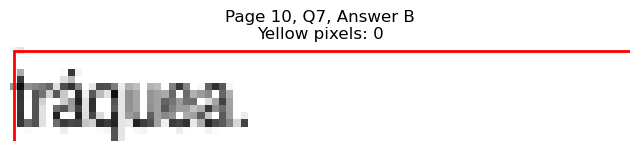

Page 10, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=372.7, y1=531.2
Page 10, Q7, C: Yellow pixels: 96
Page 10, Q7, C: Total non-white pixels: 316
Page 10, Q7, C: Yellow percentage: 30.4%


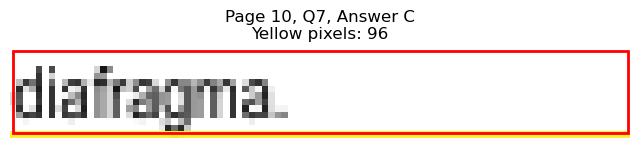

Page 10, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=364.6, y1=543.8
Page 10, Q7, D: Yellow pixels: 990
Page 10, Q7, D: Total non-white pixels: 1144
Page 10, Q7, D: Yellow percentage: 86.5%


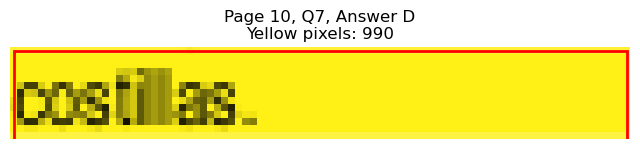


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=125.9, y1=619.6
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 286
Page 10, Q8, A: Yellow percentage: 0.0%


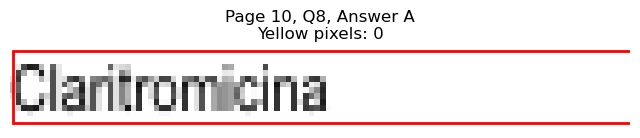

Page 10, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=118.0, y1=632.3
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 260
Page 10, Q8, B: Yellow percentage: 0.0%


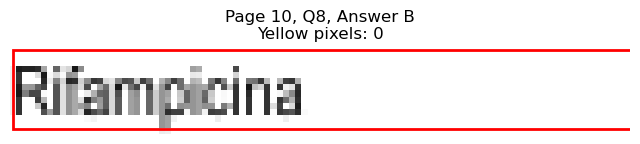

Page 10, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=387.2, y1=619.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 316
Page 10, Q8, C: Yellow percentage: 0.0%


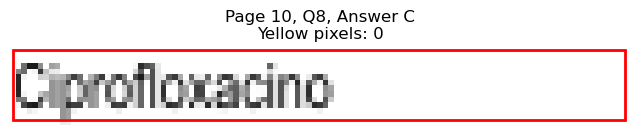

Page 10, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=382.7, y1=632.3
Page 10, Q8, D: Yellow pixels: 1058
Page 10, Q8, D: Total non-white pixels: 1484
Page 10, Q8, D: Yellow percentage: 71.3%


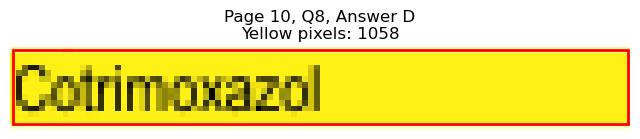


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=127.5, y1=670.1
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 323
Page 10, Q9, A: Yellow percentage: 0.0%


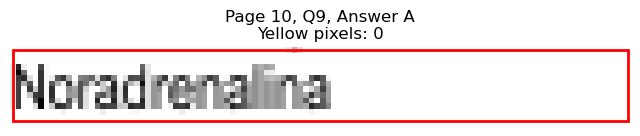

Page 10, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=112.0, y1=682.7
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 205
Page 10, Q9, B: Yellow percentage: 0.0%


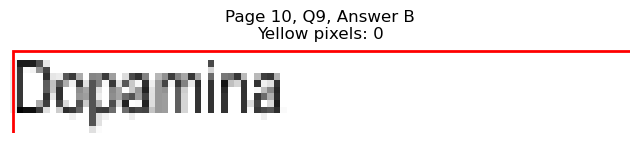

Page 10, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=375.7, y1=670.1
Page 10, Q9, C: Yellow pixels: 1084
Page 10, Q9, C: Total non-white pixels: 1386
Page 10, Q9, C: Yellow percentage: 78.2%


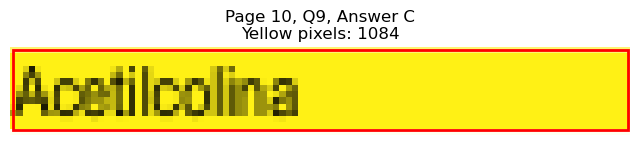

Page 10, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=373.7, y1=682.7
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 339
Page 10, Q9, D: Yellow percentage: 0.0%


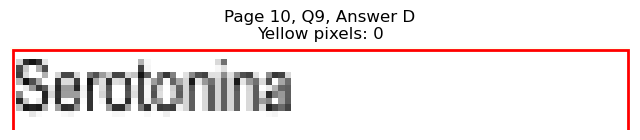


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=153.6, y1=745.8
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 400
Page 10, Q10, A: Yellow percentage: 0.0%


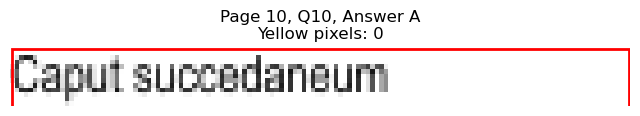

Page 10, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=168.1, y1=758.4
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 484
Page 10, Q10, B: Yellow percentage: 0.0%


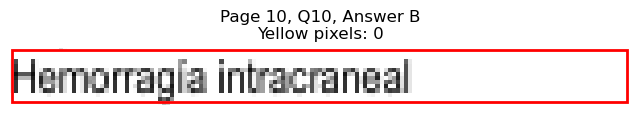

Page 10, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=398.7, y1=745.8
Page 10, Q10, C: Yellow pixels: 1311
Page 10, Q10, C: Total non-white pixels: 1586
Page 10, Q10, C: Yellow percentage: 82.7%


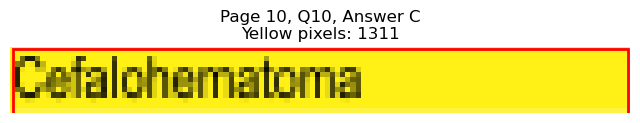

Page 10, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=415.3, y1=758.4
Page 10, Q10, D: Yellow pixels: 139
Page 10, Q10, D: Total non-white pixels: 604
Page 10, Q10, D: Yellow percentage: 23.0%


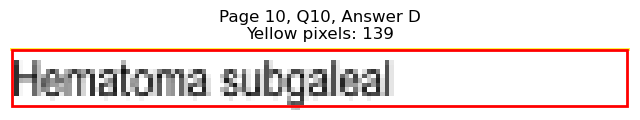


Page 10, Q10 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 6 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=123.5, y1=127.3
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 278
Page 11, Q1, A: Yellow percentage: 0.0%


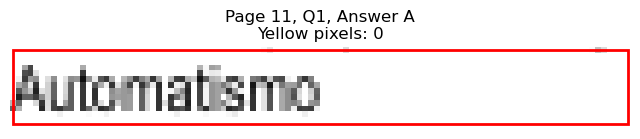

Page 11, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=132.5, y1=139.9
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 325
Page 11, Q1, B: Yellow percentage: 0.0%


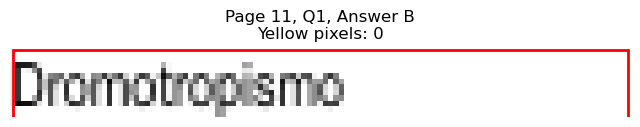

Page 11, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=389.2, y1=127.3
Page 11, Q1, C: Yellow pixels: 113
Page 11, Q1, C: Total non-white pixels: 421
Page 11, Q1, C: Yellow percentage: 26.8%


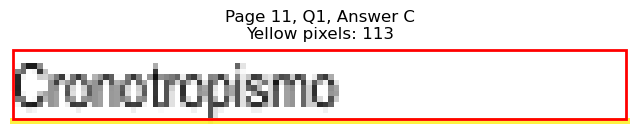

Page 11, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=377.2, y1=139.9
Page 11, Q1, D: Yellow pixels: 1111
Page 11, Q1, D: Total non-white pixels: 1313
Page 11, Q1, D: Yellow percentage: 84.6%


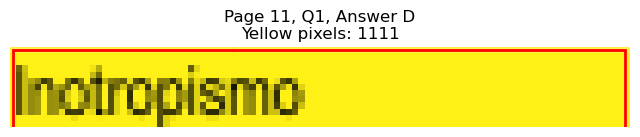


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=109.0, y1=203.0
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 199
Page 11, Q2, A: Yellow percentage: 0.0%


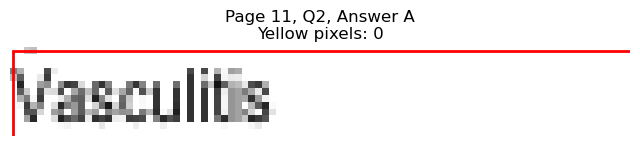

Page 11, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=139.0, y1=215.6
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 377
Page 11, Q2, B: Yellow percentage: 0.0%


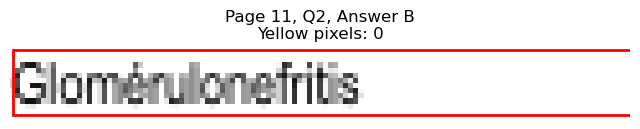

Page 11, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=422.8, y1=203.0
Page 11, Q2, C: Yellow pixels: 1529
Page 11, Q2, C: Total non-white pixels: 1898
Page 11, Q2, C: Yellow percentage: 80.6%


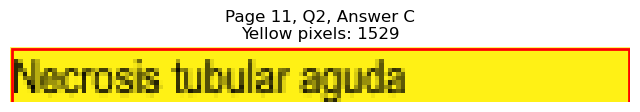

Page 11, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=400.7, y1=215.6
Page 11, Q2, D: Yellow pixels: 120
Page 11, Q2, D: Total non-white pixels: 514
Page 11, Q2, D: Yellow percentage: 23.3%


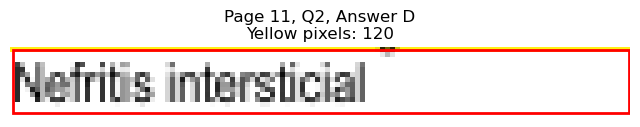


Page 11, Q2 - Selected Answer: C (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=147.0, y1=253.5
Page 11, Q3, A: Yellow pixels: 130
Page 11, Q3, A: Total non-white pixels: 535
Page 11, Q3, A: Yellow percentage: 24.3%


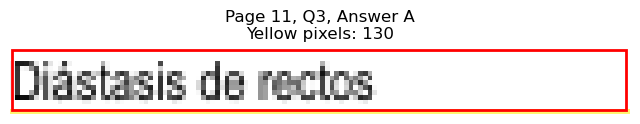

Page 11, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=133.5, y1=266.1
Page 11, Q3, B: Yellow pixels: 1112
Page 11, Q3, B: Total non-white pixels: 1624
Page 11, Q3, B: Yellow percentage: 68.5%


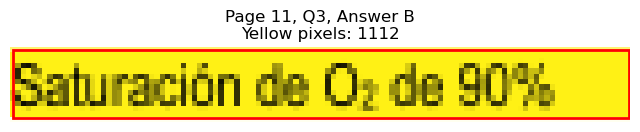

Page 11, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=423.3, y1=253.5
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 538
Page 11, Q3, C: Yellow percentage: 0.0%


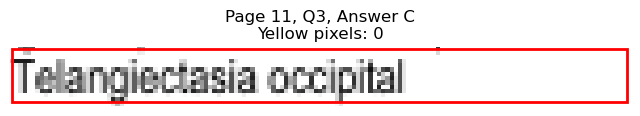

Page 11, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=385.7, y1=266.1
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 269
Page 11, Q3, D: Yellow percentage: 0.0%


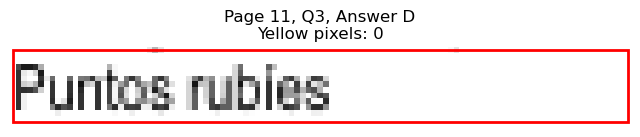


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=141.0, y1=329.3
Page 11, Q4, A: Yellow pixels: 124
Page 11, Q4, A: Total non-white pixels: 481
Page 11, Q4, A: Yellow percentage: 25.8%


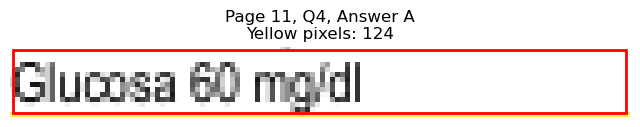

Page 11, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=158.1, y1=341.9
Page 11, Q4, B: Yellow pixels: 1508
Page 11, Q4, B: Total non-white pixels: 1833
Page 11, Q4, B: Yellow percentage: 82.3%


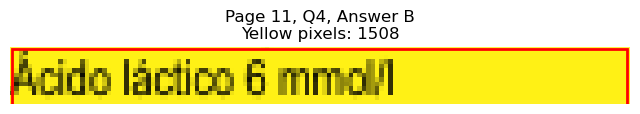

Page 11, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=405.8, y1=329.3
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 402
Page 11, Q4, C: Yellow percentage: 0.0%


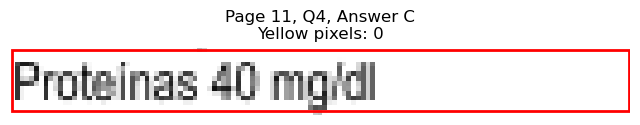

Page 11, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=428.7, y1=341.9
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 496
Page 11, Q4, D: Yellow percentage: 0.0%


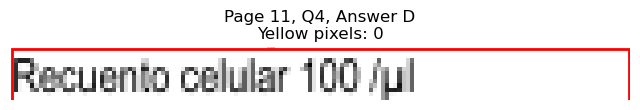


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=305.6, y1=392.4
Page 11, Q5, A: Yellow pixels: 288
Page 11, Q5, A: Total non-white pixels: 1447
Page 11, Q5, A: Yellow percentage: 19.9%


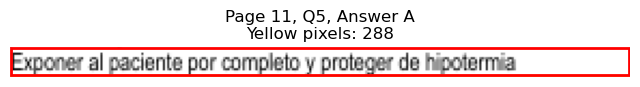

Page 11, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=362.2, y1=405.0
Page 11, Q5, B: Yellow pixels: 3392
Page 11, Q5, B: Total non-white pixels: 4485
Page 11, Q5, B: Yellow percentage: 75.6%


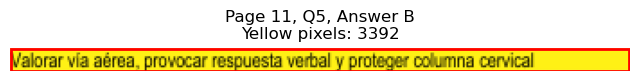

Page 11, Q5 - C: Detected box: x0=68.8, y0=404.9, x1=296.6, y1=417.6
Page 11, Q5, C: Yellow pixels: 268
Page 11, Q5, C: Total non-white pixels: 1413
Page 11, Q5, C: Yellow percentage: 19.0%


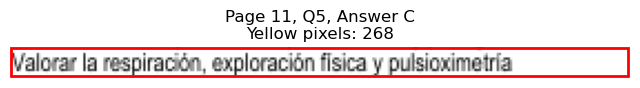

Page 11, Q5 - D: Detected box: x0=68.8, y0=417.6, x1=324.5, y1=430.3
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 1258
Page 11, Q5, D: Yellow percentage: 0.0%


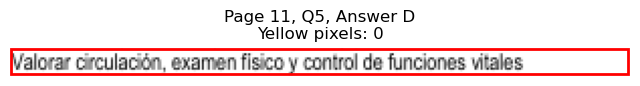


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=114.5, y1=493.4
Page 11, Q6, A: Yellow pixels: 97
Page 11, Q6, A: Total non-white pixels: 344
Page 11, Q6, A: Yellow percentage: 28.2%


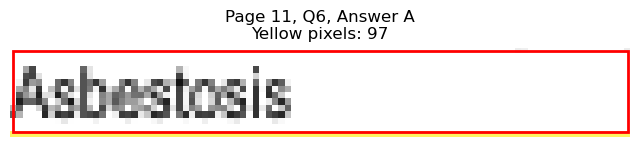

Page 11, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=107.9, y1=506.0
Page 11, Q6, B: Yellow pixels: 1007
Page 11, Q6, B: Total non-white pixels: 1170
Page 11, Q6, B: Yellow percentage: 86.1%


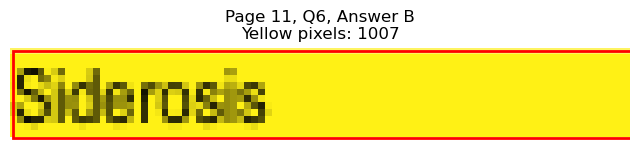

Page 11, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=364.1, y1=493.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 185
Page 11, Q6, C: Yellow percentage: 0.0%


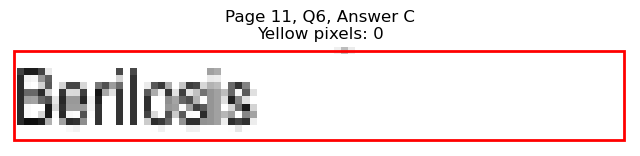

Page 11, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=362.7, y1=506.0
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 173
Page 11, Q6, D: Yellow percentage: 0.0%


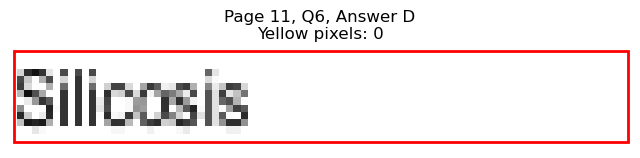


Page 11, Q6 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cómo se denominan las masas ováricas bilatera...
1   Mujer de 37 años, hace 5 meses presenta nódulo...
2   Recién nacido de un día, nacido de parto eutóc...
3   Varón de 35 años, viaja a Huaraz, acude a emer...
4   De los siguientes síntomas. ¿Cuál es caracterí...
..                                                ...
95  Mujer de 45 años, presenta oliguria posterior ...
96  En la evaluación de un recién nacido. ¿Cuál de...
97  Varón de 26 años, desde hace 5 días, presenta ...
98  De acuerdo al algoritmo de valoración del paci...
99  Varón de 58 años, trabaja desde hace 20 años e...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                 Tumor de Krukenberg   
1                                             Medular   
2                             Osteomielitis de hombro   
3                                   Diuréticos de asa   
4                                             Disuria   
..                                                ...   
95                                         Vasculitis   
96                                Diástasis de rectos   
97                                   Glucosa 60 mg/dl   
98  Exponer al paciente por completo y proteger de...   
99                                         Asbestosis   

                                             option_B  \
0                         Tumor de células de Sertoli   
1                                           Folicular   
2                                   Trauma obstétrico   
3                               Oxigenoterapia con O2   
4                                  Nicturia frecuente   
..                                                ...   
95                                  Glomérulonefritis   
96                            Saturación de O2 de 90%   
97                             Ácido láctico 6 mmol/l   
98  Valorar vía aérea, provocar respuesta verbal y...   
99                                          Siderosis   

                                             option_C  \
0                                    Tumor de Brenner   
1                                             Papilar   
2                                   Sífilis congénita   
3                    Oxigenoterapia con Óxido Nítrico   
4                               Pierde orina al toser   
..                                                ...   
95                             Necrosis tubular aguda   
96                           Telangiectasia occipital   
97                                 Proteínas 40 mg/dl   
98  Valorar la respiración, exploración física y p...   
99                                          Berilosis   

                                             option_D  
0                                         Fibrotecoma  
1                                          Anaplásico  
2                                    Artritis séptica  
3                                       Acetazolamida  
4                             Perdida escasa de orina  
..                                                ...  
95                              Nefritis intersticial  
96                                      Puntos rubíes  
97                           Recuento celular 100 /µl  
98  Valorar circulación, examen físico y control d...  
99                                          Silicosis  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               C
2               C
3               B
4               B
..            ...
95              C
96              B
97              B
98              B
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cómo se denominan las masas ováricas bilatera...   
1   Mujer de 37 años, hace 5 meses presenta nódulo...   
2   Recién nacido de un día, nacido de parto eutóc...   
3   Varón de 35 años, viaja a Huaraz, acude a emer...   
4   De los siguientes síntomas. ¿Cuál es caracterí...   
..                                                ...   
95  Mujer de 45 años, presenta oliguria posterior ...   
96  En la evaluación de un recién nacido. ¿Cuál de...   
97  Varón de 26 años, desde hace 5 días, presenta ...   
98  De acuerdo al algoritmo de valoración del paci...   
99  Varón de 58 años, trabaja desde hace 20 años e...   

                                             option_A  \
0                                 Tumor de Krukenberg   
1                                             Medular   
2                             Osteomielitis de hombro   
3                                   Diuréticos de asa   
4                                             Disuria   
..                                                ...   
95                                         Vasculitis   
96                                Diástasis de rectos   
97                                   Glucosa 60 mg/dl   
98  Exponer al paciente por completo y proteger de...   
99                                         Asbestosis   

                                             option_B  \
0                         Tumor de células de Sertoli   
1                                           Folicular   
2                                   Trauma obstétrico   
3                               Oxigenoterapia con O2   
4                                  Nicturia frecuente   
..                                                ...   
95                                  Glomérulonefritis   
96                            Saturación de O2 de 90%   
97                             Ácido láctico 6 mmol/l   
98  Valorar vía aérea, provocar respuesta verbal y...   
99                                          Siderosis   

                                             option_C  \
0                                    Tumor de Brenner   
1                                             Papilar   
2                                   Sífilis congénita   
3                    Oxigenoterapia con Óxido Nítrico   
4                               Pierde orina al toser   
..                                                ...   
95                             Necrosis tubular aguda   
96                           Telangiectasia occipital   
97                                 Proteínas 40 mg/dl   
98  Valorar la respiración, exploración física y p...   
99                                          Berilosis   

                                             option_D correct_answer  
0                                         Fibrotecoma              A  
1                                          Anaplásico              C  
2                                    Artritis séptica              C  
3                                       Acetazolamida              B  
4                             Perdida escasa de orina              B  
..                                                ...            ...  
95                              Nefritis intersticial              C  
96                                      Puntos rubíes              B  
97                           Recuento celular 100 /µl              B  
98  Valorar circulación, examen físico y control d...              B  
99                                          Silicosis              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/PRUEBA B.csv
